<a href="https://colab.research.google.com/github/alunfes/1m-btc-data/blob/master/Decision_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi

Tue Mar  7 08:28:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
#!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!wget https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2023-03-07 08:28:14--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving sourceforge.net (sourceforge.net)... 104.18.11.128, 104.18.10.128, 2606:4700::6812:b80, ...
Connecting to sourceforge.net (sourceforge.net)|104.18.11.128|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/ [following]
--2023-03-07 08:28:14--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download [following]
--2023-03-07 08:28:14--  https://sourceforge.net/projects/ta-lib/files/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz/download
Reusing existing connection to sourceforge.net:443.
HTTP request sent, awaiting r

In [4]:
!pip install stable-baselines3
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
%load_ext cython

In [6]:
import numpy as np
import pandas as pd
import gym
import talib as ta
import matplotlib.pyplot as plt
import random
import math
import time
import cython
import itertools
import sys
import copy

import scipy
from sklearn.preprocessing import MinMaxScaler
from scipy import fftpack, signal
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, RobustScaler, QuantileTransformer
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torch.optim import Adam
from collections import deque, namedtuple
import torch.nn.init as init
import torch.utils.data as data
import torch.utils as utils

from numba import jit, f8, i8
from numba.experimental import jitclass

In [7]:


class MarketData:
    @classmethod
    def initialize(cls, terms, sampling_window, data_length):
        st = time.time()
        cls.terms = terms
        cls.sampling_window = sampling_window
        cls.data_length = data_length
        cls.df = pd.DataFrame()
        cls.ts = []
        cls.open = []
        cls.high = []
        cls.low = []
        cls.close = []
        cls.vol = []
        cls.__read_data()
        cls.logopen = list(np.log(cls.open))
        cls.loghigh = list(np.log(cls.high))
        cls.loglow = list(np.log(cls.low))
        cls.logclose = list(np.log(cls.close))
        cls.close_change_ratio = list(np.array(pd.DataFrame(cls.close).pct_change().values.tolist()).reshape(len(cls.close)))
        cls.logclose_change_ratio = list(np.array(pd.DataFrame(cls.logclose).pct_change().values.tolist()).reshape(len(cls.logclose)))
        cls.log_ohlc = {} #term1:list, terms2:list....
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.__calc_index()
        cls.all_index = {}
        #cls.__calc_all_index()

        cls.sampled_ts = []
        cls.std = []
        cls.skew = []
        cls.kurtosis = []
        cls.mean = []
        cls.median = []
        cls.mode = []
        cls.max_min_ratio = []
        cls.total_change_ratio = []
        cls.period_change_ratio = []
        cls.max_end_ratio = []
        cls.min_end_ratio = []
        cls.sampled_data = []
        #cls.__get_sampling_data()
        print('Completed Market Data, time=', time.time() - st)
    
    @classmethod
    def __read_data(cls):
        cls.df = pd.read_csv('/content/drive/My Drive/BTC-PERP-1mcp.csv')
        cls.ts = list(cls.df['ts'])
        cls.open = list(cls.df['open'])
        cls.high = list(cls.df['high'])
        cls.low = list(cls.df['low'])
        cls.close = list(cls.df['close'])
        cls.vol = list(cls.df['volume'])

    @classmethod
    def __calc_index(cls):
        for term in cls.terms:
            cls.ma_kairi[term] = cls.__calc_ma_kairi(term)
            cls.rsi[term] = cls.__calc_rsi(term)
            cls.williams_R[term] = cls.__calc_williams_R(term)
            cls.macd[term] = cls.__calc_macdfix(term)
            cls.aroon_os[term] = cls.__calc_aroon_os(term)
            cls.cci[term] = cls.__calc_cci(term)
            cls.dx[term] = cls.__calc_dx(term)
            cls.stochastic[term] = cls.__calc_stochastic(term)
            cls.cmo[term] = cls.__calc_cmo(term)
            cls.adxr[term] = cls.__calc_adxr(term)
            cls.apo[term] = cls.__calc_apo(term)
            cls.plus_minus_di[term] = cls.__calc_plus_minus_di(term)
            cls.ppo[term] = cls.__calc_ppo(term)
            cls.ultosc[term] = cls.__calc_ultosc(term)

    #sklearn minmax scalerよりもこっちの方が少しだけ早い
    @classmethod
    def __minmax_scaler(cls, data):
        data_min = np.min(data)
        data_max = np.max(data)
        data_scaled = (data - data_min) / (data_max - data_min)
        return data_scaled


    @classmethod
    def __data_sampler(cls, current_ind:int, term:int, num_nn_units:int):
        sampling_rate = int(term / num_nn_units)
        sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
        return np.array(cls.logclose)[sampling_indices]


    @classmethod
    def get_nn_input(cls, current_ind:int, num_nn_units:int, short_term:int, mid_term1:int, mid_term2:int, long_term1:int, long_term2:int):
        short_data = cls.__data_sampler(current_ind, short_term, num_nn_units)
        mid_data1 = cls.__data_sampler(current_ind, mid_term1, num_nn_units)
        mid_data2 = cls.__data_sampler(current_ind, mid_term2, num_nn_units)
        long_data1 = cls.__data_sampler(current_ind, long_term1, num_nn_units)
        long_data2 = cls.__data_sampler(current_ind, long_term2, num_nn_units)
        rsi = [MarketData.rsi[x][current_ind] for x in list(MarketData.rsi.keys())]

        return {'md_short':cls.__minmax_scaler(short_data), 
         'md_mid1':cls.__minmax_scaler(mid_data1), 
         'md_mid2':cls.__minmax_scaler(mid_data2), 
         'md_long1':cls.__minmax_scaler(long_data1), 
         'md_long2':cls.__minmax_scaler(long_data2),
         'md_rsi':rsi}


    @classmethod
    def get_ohlc(cls, index:int):
        return [cls.open[index], cls.high[index], cls.low[index], cls.close[index]]

    @classmethod
    def __calc_all_index(cls):
        for term in cls.terms:
            cls.all_index['ma_kairi_'+str(term)] = cls.__calc_ma_kairi(term)
            cls.all_index['rsi_'+str(term)] = cls.__calc_rsi(term)
            cls.all_index['williams_R_'+str(term)] = cls.__calc_williams_R(term)
            cls.all_index['macd_'+str(term)] = cls.__calc_macdfix(term)
            cls.all_index['aroon_os_'+str(term)] = cls.__calc_aroon_os(term)
            cls.all_index['cci_'+str(term)] = cls.__calc_cci(term)
            cls.all_index['dx_'+str(term)] = cls.__calc_dx(term)
            cls.all_index['stochastic_'+str(term)] = cls.__calc_stochastic(term)
            cls.all_index['cmo_'+str(term)] = cls.__calc_cmo(term)
            cls.all_index['adxr_'+str(term)] = cls.__calc_adxr(term)
            cls.all_index['apo_'+str(term)] = cls.__calc_apo(term)
            cls.all_index['di_'+str(term)] = cls.__calc_plus_minus_di(term)
            cls.all_index['ppo_'+str(term)] = cls.__calc_ppo(term)
            cls.all_index['ultosc_'+str(term)] = cls.__calc_ultosc(term)

    #initialize index after obtained converted data for NN input
    @classmethod
    def initialize_index_data(cls):
        cls.ma_kairi = {}
        cls.rsi = {}
        cls.williams_R = {}
        cls.macd = {}
        cls.aroon_os = {}
        cls.cci = {}
        cls.dx = {}
        cls.stochastic = {}
        cls.cmo = {}
        cls.adxr = {}
        cls.apo = {}
        cls.plus_minus_di = {}
        cls.ppo = {}
        cls.ultosc = {}
        cls.all_index = {}

    @classmethod
    def __get_sampling_data(cls):
        count = 0
        current_start = 0
        while True:
            data = cls.close[current_start : current_start + cls.data_length]
            change_ratio = data / np.roll(data, 1)
            change_ratio = change_ratio[1:]
            maxv = max(data)
            minv = min(data)
            cls.sampled_ts.append(cls.ts[current_start + cls.data_length - 1])
            cls.mean.append(np.mean(change_ratio))
            cls.std.append(np.std(change_ratio))
            cls.skew.append(scipy.stats.skew(change_ratio))
            cls.kurtosis.append(scipy.stats.kurtosis(change_ratio))
            cls.mode.append(scipy.stats.mode(change_ratio)[0][0])
            cls.max_min_ratio.append(maxv / minv)
            cls.period_change_ratio.append(data[-1] / data[0])
            cls.total_change_ratio.append(100 * np.mean(np.diff(data) / np.mean(data)))
            cls.max_end_ratio.append(data[-1] / maxv)
            cls.max_end_ratio.append(data[-1] / minv)
            current_start += cls.sampling_window
            if current_start + cls.data_length >= len(cls.close):
                break
        for i in range(len(cls.sampled_ts)):
            cls.sampled_data.append([cls.mean[i], cls.std[i], cls.skew[i], cls.kurtosis[i], cls.mode[i], cls.max_min_ratio[i],
                                     cls.period_change_ratio[i], cls.total_change_ratio[i], cls.max_end_ratio[i],
                                     cls.max_end_ratio[i]])


    @classmethod
    def __calc_ma_kairi(cls, term):
        ma = list(ta.MA(np.array(cls.close, dtype='f8'), timeperiod=term))
        return list(map(lambda c, e: (c - e) / e, np.array(cls.close, dtype='f8'), np.array(ma, dtype='f8')))
    
    @classmethod
    def __calc_rsi(cls, term):
        return ta.RSI(np.array(cls.logclose, dtype='f8'), timeperiod=term) / 100.0
    
    @classmethod
    def __calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'),timeperiod=term))
        
    @classmethod
    def __calc_macdfix(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.logclose, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd

    @classmethod
    def __calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_cci(cls, term):
        return list(ta.CCI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_dx(cls, term):
        return list(ta.DX(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_stochastic(cls, term):
        k_term = term
        d_term = int(term / 2.0)
        fastk, fastd = ta.STOCHF(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), fastk_period=k_term, fastd_period=d_term, fastd_matype=0)
        return list(np.array(fastk) / np.array(fastd))


    @classmethod
    def __calc_cmo(cls, term):
        return list(ta.CMO(np.array(cls.logclose, dtype='f8'), timeperiod=term))

    @classmethod
    def __calc_adxr(cls, term):
        return ta.ADXR(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)

    @classmethod
    def __calc_apo(cls, term):
        fperiod=term
        speriod=term * 2
        return ta.APO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_plus_minus_di(cls, term):
        mdi = ta.MINUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        pdi = ta.PLUS_DI(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod=term)
        return list(np.array(mdi) / np.array(pdi))

    @classmethod
    def __calc_ppo(cls, term):
        fperiod = term
        speriod = term * 2
        return ta.PPO(np.array(cls.logclose, dtype='f8'), fastperiod=fperiod, slowperiod=speriod, matype=0)

    @classmethod
    def __calc_ultosc(cls, term):
        p2 = int(term / 2.0)
        p1 = int(term / 3.0)
        return ta.ULTOSC(np.array(cls.loghigh, dtype='f8'), np.array(cls.loglow, dtype='f8'), np.array(cls.logclose, dtype='f8'), timeperiod1=p1, timeperiod2=p2, timeperiod3=term)

sampling_window = 1
data_length = 60
MarketData.initialize([5, 60, 240, 1440, 10080], sampling_window, data_length)

<ipython-input-7-9274ffb3f172>:227: RuntimeWarning: invalid value encountered in true_divide
  return list(np.array(fastk) / np.array(fastd))


Completed Market Data, time= 81.36896920204163


In [8]:
################################################################################
############################# NN Wrapper of Market Data #############################
################################################################################
class MarketDataNNWrapper:
    @staticmethod
    @jit(f8[:](i8, i8, i8, f8[:]))
    def __data_sampler(current_ind:int, term:int, num_nn_units:int, data):
        sampling_rate = int(term / num_nn_units)
        sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
        return data[sampling_indices]

    @staticmethod
    @jit(f8[:](f8[:]))
    def __minmax_scaler(data):
        data_min = np.min(data)
        data_max = np.max(data)
        data_scaled = (data - data_min) / (data_max - data_min)
        return data_scaled


    def get_nn_input(self, data, rsi, current_ind:int, num_nn_units:int, short_term:int, mid_term1:int, mid_term2:int, long_term1:int, long_term2:int):
        short_data = self.__data_sampler(current_ind, short_term, num_nn_units, data)
        mid_data1 = self.__data_sampler(current_ind, mid_term1, num_nn_units, data)
        mid_data2 = self.__data_sampler(current_ind, mid_term2, num_nn_units, data)
        long_data1 = self.__data_sampler(current_ind, long_term1, num_nn_units, data)
        long_data2 = self.__data_sampler(current_ind, long_term2, num_nn_units, data)
        rsi_res = [rsi[x][current_ind] for x in list(rsi.keys())]
        rsi_res.extend([0] * (num_nn_units - len(rsi_res)))
        return [self.__minmax_scaler(short_data), 
         self.__minmax_scaler(mid_data1), 
         self.__minmax_scaler(mid_data2), 
         self.__minmax_scaler(long_data1), 
         self.__minmax_scaler(long_data2),
         np.array(rsi_res)]

    def get_nn_input_length(self, data, rsi, current_ind:int, num_nn_units:int, short_term:int, mid_term1:int, mid_term2:int, long_term1:int, long_term2:int):
        market_data = self.get_nn_input(data, rsi, current_ind, num_nn_units, short_term, mid_term1, mid_term2, long_term1, long_term2)
        return {
            'short_length':len(market_data[0]), 
            'mid1_length':len(market_data[1]), 
            'mid2_length':len(market_data[2]), 
            'long1_length':len(market_data[3]),
            'long2_length':len(market_data[4]),
            'rsi_length':len(market_data[5])
            }

'''
mdnw = MarketDataNNWrapper()
d = np.array(MarketData.logclose)
rsi = MarketData.rsi
for i in range(10):
    data = mdnw.get_nn_input(d, rsi, i + 100000, 60, 120, 720, 4800, 12000, 48000)
    print(data[0].shape, data[-1].shape)
'''

'\nmdnw = MarketDataNNWrapper()\nd = np.array(MarketData.logclose)\nrsi = MarketData.rsi\nfor i in range(10):\n    data = mdnw.get_nn_input(d, rsi, i + 100000, 60, 120, 720, 4800, 12000, 48000)\n    print(data[0].shape, data[-1].shape)\n'

In [9]:
################################################################################
################################ Trading Environment #################################
################################################################################
%%cython -a
import numpy as np
import random
import itertools
cimport numpy as cnp

cdef class AccountEnv:
    #for system
    cdef public int flg_display
    cdef public double is_done_pnl_ratio
    cdef public int is_done_no_holding_period
    cdef public int no_holding_period
    #Asset, fee,    
    cdef public double cash
    cdef public double default_cash
    cdef public double market_order_fee
    cdef public double limit_order_fee    
    cdef public int duration
    cdef public int order_distribution_num
    cdef public double min_holding_size

    #holding
    cdef public int holding_side
    cdef public double holding_price
    cdef public double holding_size
    cdef public double holding_amount
    cdef public int holding_period
    


    #order
    cdef public list buy_orders
    cdef public list sell_orders
    cdef public list pt_orders
    cdef public dict lc_order
    cdef public list order_ids
    cdef public int order_id_last
    cdef public double buy_order_ratio_start
    cdef public double buy_order_ratio_end
    cdef public double sell_order_ratio_start
    cdef public double sell_order_ratio_end
    cdef public int buy_order_dist_type
    cdef public int sell_order_dist_type
    cdef public double pt_ratio_start
    cdef public double pt_ratio_end
    cdef public double lc_ratio
    cdef public list pt_ids
    cdef public int pt_id_last

    #performance
    cdef public double realized_pnl
    cdef public double unrealized_pnl
    cdef public double total_pnl
    cdef public double pre_entry_total_pnl
    cdef public double total_fee
    cdef public int num_trade #holding sideが変わった時にカウント
    cdef public int num_win #holding sideが変わった時のtotal_pnlをpre_entry_total_pnlに記録して次にsideが変わった時のtotal_pnlと増減でカウント
    cdef public double win_rate

    
    #log
    cdef public list log_total_pnl
    cdef public list log_close_price

    #params for state
    cdef public double state_scaler_min #to rescale order price divergence, unrealized pnl ratio, -0.1
    cdef public double state_scaler_max #0.1
    cdef public int state_scaler_bin

    #for RFL
    cdef public int is_done #0:false, 1:true

    #state
    cdef public cnp.ndarray state
    cdef public int state_length
    cdef public list state_holding_buy_side
    cdef public list state_holding_sell_side
    cdef public list state_holding_size_percentage
    cdef public list state_holding_sell_size_percentage
    cdef public list state_buy_order_size_percentage
    cdef public list state_sell_order_size_percentage
    cdef public list state_pt_order
    cdef public list state_lc_order
    cdef public list state_buy_order_divergence #3%を上限とした乖離率
    cdef public list state_sell_order_divergence #3%を上限とした乖離率
    cdef public list state_pt_order_divergence
    cdef public list state_lc_order_divergence
    cdef public list state_cancel_buy
    cdef public list state_cancel_sell
    cdef public list state_cancel_pt
    cdef public list state_cancel_lc
    cdef public list state_market_close
    cdef public list state_unrealized_pnl #-5% - +5%の範囲で0-1に変換
    cdef public double order_divergence_kijun
    cdef public double unrealized_pnl_kijun
    

    #reward
    cdef public double reward
    cdef public bint reward_invalid_action
    cdef public bint reward_loss
    cdef public bint reward_profit
    cdef public bint reward_no_action_no_holding
    

    
    '''
    save: 適切なrewardの設定

    ・agentは時刻tのohlcで判断する。ENVはt+1のohlcで約定判断等する。
    ・order, pt/lcがある状態で注文を入れても無効扱いとなる。（既存のorderキャンセルして新しい注文を優先させるようにもできる）
    ・ptは複数のlimit orderとして出す。1 pt order当たりのsizeは常にholding size / 残っているpt order数
    ・entryは毎回同じ金額の保有を想定して行う。 （limit orderは追加で入れることができない仕様　＋　entry時のサイズはdefault cashの値を基準に計算）

    stete:
    各種データの時系列配列
    position_buy, position_sell, position_size /default_cash, order

    pt_ratio_start = 0.01 - 0.05 (should be largar than limit order fee)
    pt_ratio_end = 0.01 - 0.05 (it actually limit order price width)
    lc_ratio = 0.01 - 0.1
    order_ratio_start = 0.001 - 0.05
    order_ratio_end = 0.01 - 0.05 (it actually limit order price width, start ratio + end ratio)
    '''
    def __cinit__(self, flg_display:int, is_done_pnl_ratio:double, is_done_no_holding_period:int, order_distribution_num:int, market_order_fee:double, limit_order_fee:double, state_length:int):
        #trading settings
        self.flg_display = flg_display #0:not display, 1:display
        self.default_cash = 10000 #always 
        self.order_distribution_num = order_distribution_num
        self.is_done_pnl_ratio = is_done_pnl_ratio
        self.is_done_no_holding_period = is_done_no_holding_period
        self.market_order_fee = market_order_fee #0.006
        self.limit_order_fee = limit_order_fee #0.001
        self.min_holding_size = 0.01 #minimum percentage of holding size per default_cash, it should treat as full exit if holding size after exec of exit order fall below this value
        #params for state generation
        self.state_length = state_length
        self.order_divergence_kijun = 0.03
        self.unrealized_pnl_kijun = 0.05
        self.reset()



        #state
    cpdef void __initialize_state(self):        
        self.state_holding_buy_side = [0] * self.state_length
        self.state_holding_sell_side = [0] * self.state_length
        self.state_holding_size_percentage = [0] * self.state_length
        self.state_buy_order_size_percentage = [0] * self.state_length
        self.state_sell_order_size_percentage = [0] * self.state_length
        self.state_pt_order = [0] * self.state_length
        self.state_lc_order = [0] * self.state_length
        self.state_buy_order_divergence = [1] * self.state_length
        self.state_sell_order_divergence = [1] * self.state_length
        self.state_pt_order_divergence = [1] * self.state_length
        self.state_lc_order_divergence = [1] * self.state_length
        self.state_cancel_buy = [0] * self.state_length
        self.state_cancel_sell = [0] * self.state_length
        self.state_cancel_pt = [0] * self.state_length
        self.state_cancel_lc = [0] * self.state_length
        self.state_market_close = [0] * self.state_length
        self.state_unrealized_pnl = [0] * self.state_length

    
    cpdef void __initialize_reward(self):
        self.reward = 0
        self.reward_invalid_action = False
        self.reward_loss = False
        self.reward_profit = False
        self.reward_no_action_no_holding = False
        


    cpdef tuple reset(self):
        self.cash = self.default_cash
        self.realized_pnl = 0 #cash base
        self.unrealized_pnl = 0 #cash base
        self.pre_entry_total_pnl = 0
        self.no_holding_period = 0
        self.total_pnl = 0
        self.num_trade = 0
        self.num_win = 0
        self.win_rate = 0
        self.total_fee = 0
        self.duration = 0
        self.log_total_pnl = []
        self.log_close_price = []
        self.__initialize_holding()
        self.__initialize_order()
        self.__initialize_state()
        self.__initialize_reward()
        self.is_done = self.__check_is_done()
        self.reward = self.__calc_reward()
        self.state = self.__generate_state([0,0,0,0], 0, 0.0)
        return (self.state, self.reward, self.is_done)

    '''
    無効な行動した場合は-1
    order cancelしてpt, lc残っていたら-1
    損したら-1
    利益出したら1
    no order or no positionでno actionだったら-1

    '''
    cpdef double __calc_reward(self):
        if self.reward_profit:
            return 1
        elif self.reward_loss:
            return -1
        elif self.reward_invalid_action:
            return -0.1
        elif self.reward_no_action_no_holding:
            return -0.1
        else:
            return 0.1


    cpdef tuple get_state_length(self):
        state = self.__generate_state([1,1,1,1], 0, 0)
        return ({
            'state_holding_buy_side':len(state[0]),
            'state_holding_sell_side':len(state[1]),
            'state_holding_size_percentage':len(state[2]),
            'state_buy_order_size_percentage':len(state[3]),
            'state_sell_order_size_percentage':len(state[4]),
            'state_pt_order':len(state[5]),
            'state_lc_order':len(state[6]),
            'state_buy_order_divergence':len(state[7]),
            'state_sell_order_divergence':len(state[8]),
            'state_pt_order_divergence':len(state[9]),
            'state_lc_order_divergence':len(state[10]),
            'state_cancel_buy':len(state[11]),
            'state_cancel_sell':len(state[11]),
            'state_cancel_pt':len(state[12]),
            'state_cancel_lc':len(state[13]),
            'state_market_close':len(state[14]),
            'state_unrealized_pnl':len(state[15])}, 0)


    cpdef cnp.ndarray __generate_state(self, list ohlc_t1, int action, double market_close_ratio):
        self.state_holding_buy_side.append(1 if self.holding_side == 1 else 0)
        self.state_holding_sell_side.append(1 if self.holding_side == -1 else 0)
        self.state_holding_size_percentage.append(0 if self.holding_side ==0 else round(self.holding_size * ohlc_t1[-1] / self.default_cash,4))
        self.state_buy_order_size_percentage.append(0 if len(self.buy_orders) == 0 else round(sum([d['price'] * d['size'] for d in self.buy_orders]) / self.default_cash, 4))
        self.state_sell_order_size_percentage.append(0 if len(self.sell_orders) == 0 else round(sum([d['price'] * d['size'] for d in self.sell_orders]) / self.default_cash, 4))
        self.state_pt_order.append(0 if len(self.pt_orders) == 0 else 1)
        self.state_lc_order.append(0 if len(self.lc_order) == 0 else 1)
        self.state_buy_order_divergence.append(1 if len(self.buy_orders) == 0 else max(round(((ohlc_t1[2] - self.buy_orders[0]['price']) / self.buy_orders[0]['price']) / self.order_divergence_kijun, 4), 1.0))
        self.state_sell_order_divergence.append(1 if len(self.sell_orders) == 0 else max(round(((self.sell_orders[0]['price'] - ohlc_t1[1]) / self.sell_orders[0]['price']) / self.order_divergence_kijun, 4), 1.0))
        self.state_pt_order_divergence.append(1 if len(self.pt_orders) == 0 else max(round( (self.pt_orders[0]['ratio'] + (self.holding_side * (self.holding_price - ohlc_t1[-1]) / self.holding_price)) / self.order_divergence_kijun, 4), 1.0))
        self.state_lc_order_divergence.append(1 if len(self.lc_order) == 0 else max(round( (self.lc_order['ratio'] + (self.holding_side * (self.holding_price - ohlc_t1[-1]) / self.holding_price)) / self.order_divergence_kijun, 4), 1.0))
        self.state_cancel_buy.append(1 if action == 5 else 1 if action == 9 else 0)
        self.state_cancel_sell.append(1 if action == 6 else 1 if action == 9 else 0)
        self.state_cancel_pt.append(1 if action == 7 else 1 if action == 9 else 0)
        self.state_cancel_lc.append(1 if action == 8 else 1 if action == 9 else 0)
        self.state_market_close.append(market_close_ratio if action == 10 else 0)
        self.state_unrealized_pnl.append(0 if self.unrealized_pnl < (-self.unrealized_pnl_kijun * self.default_cash) else 1 if self.unrealized_pnl > (self.unrealized_pnl_kijun * self.default_cash) else self.unrealized_pnl / self.default_cash)
        #state用のデータが一定以上の長さになったら一部削除する
        if len(self.state_holding_buy_side) > self.state_length * 2.1:
            del self.state_holding_buy_side[0:self.state_length]
            del self.state_holding_sell_side[0:self.state_length]
            del self.state_holding_size_percentage[0:self.state_length]
            del self.state_buy_order_size_percentage[0:self.state_length]
            del self.state_sell_order_size_percentage[0:self.state_length]
            del self.state_pt_order[0:self.state_length]
            del self.state_lc_order[0:self.state_length]
            del self.state_buy_order_divergence[0:self.state_length]
            del self.state_sell_order_divergence[0:self.state_length]
            del self.state_pt_order_divergence[0:self.state_length]
            del self.state_lc_order_divergence[0:self.state_length]
            del self.state_cancel_buy[0:self.state_length]
            del self.state_cancel_sell[0:self.state_length]
            del self.state_cancel_pt[0:self.state_length]
            del self.state_cancel_lc[0:self.state_length]
            del self.state_market_close[0:self.state_length]
            del self.state_unrealized_pnl[0:self.state_length]
        return np.array([self.state_holding_buy_side[-self.state_length:],
                self.state_holding_sell_side[-self.state_length:],
                self.state_holding_size_percentage[-self.state_length:],
                self.state_buy_order_size_percentage[-self.state_length:],
                self.state_sell_order_size_percentage[-self.state_length:],
                self.state_pt_order[-self.state_length:],
                self.state_lc_order[-self.state_length:],
                self.state_buy_order_divergence[-self.state_length:],
                self.state_sell_order_divergence[-self.state_length:],
                self.state_pt_order_divergence[-self.state_length:],
                self.state_lc_order_divergence[-self.state_length:],
                self.state_cancel_buy[-self.state_length:],
                self.state_cancel_sell[-self.state_length:],
                self.state_cancel_pt[-self.state_length:],
                self.state_cancel_lc[-self.state_length:],
                self.state_market_close[-self.state_length:],
                self.state_unrealized_pnl[-self.state_length:]])


    #-0.05から0.05の範囲の値をいい感じに10の01に変換する間数、使ってない。
    '''
    cpdef cnp.ndarray generate_input_array(self, double unrealized_pnl):
        unrealized_pnl = 0.05 if unrealized_pnl > 0.05 else -0.05 if unrealized_pnl < -0.05 else unrealized_pnl
        kizami = (0.05 - (-0.05)) / 10
        index = int((v + 0.05) / kizami)
        result = [0] * 10
        result[:index] = [1] * index
        if index < 10:
            result[index] = (unrealized_pnl + 0.05 - kizami * index) / kizami
        return result
    '''

    cpdef cnp.ndarray __scale_data(self, double actual_v):
        return np.histogram([actual_v], bins=self.state_scaler_bin, range=(self.state_scaler_min, self.state_scaler_max))[0]
        

    cpdef void __initialize_order(self):
        self.buy_orders = [] #{'id', 'price', 'size', 'ratio'} *side:1 or -1, size:actual BTC vol, ratio:percentage (0-1)
        self.sell_orders = [] #{'id', 'price', 'size', 'ratio'} *side:1 or -1, size:actual BTC vol, ratio:percentage (0-1)
        self.buy_order_dist_type = -1 #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.sell_order_dist_type = -1 #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.order_ids = [] #start from 0
        self.order_id_last = 0
        self.pt_orders = [] #{'status', 'id', 'side', 'pt ratio'} 、サイズは全て同じ（holding_size / num_pt_orders)
        self.lc_order = {} #{'side', 'lc ratio'}
        self.pt_ids = [] #start from 0
        self.pt_id_last = 0


    cpdef void __initialize_holding(self):
        self.cash = self.default_cash
        self.holding_side = 0 
        self.holding_price = 0
        self.holding_size = 0
        self.holding_amount = 0
        self.holding_period = 0
    
    cpdef void __update_holding(self, int side, double price, double size):
        if self.holding_side != side:
            self.holding_period = 0
            if self.holding_side != 0: #現在ポジション持っていてexit、opposite entryした場合は勝ち負け判定して現時点のtotal pnlを記録
                if self.pre_entry_total_pnl < self.total_pnl:
                    self.num_win += 1
                    self.reward_profit = True
                self.pre_entry_total_pnl = self.total_pnl
                self.num_trade += 1
                self.reward_loss = True
        self.holding_side = side
        self.holding_price = price
        self.holding_size = size
        self.holding_amount = size * price
    

    cpdef tuple action_space_sample(self):
        action_id = random.randint(0,10)
        order_dist_type = random.randint(0, 4)
        order_price_start_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        order_price_width_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        pt_price_start_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        pt_price_width_ratio = random.randint(10, 50) / 1000.0 #0.01 - 0.05
        num_pt_div = random.randint(2, 10)
        lc_ratio = random.randint(5, 50) / 1000.0 #0.005 - 0.05
        market_close_ratio = random.randint(10, 100) / 100.0
        action = (action_id, order_dist_type, order_price_start_ratio, order_price_width_ratio, pt_price_start_ratio, pt_price_width_ratio, num_pt_div, lc_ratio, market_close_ratio)
        return action

    '''
    price_start_ratio, price_end_ratio: i.e. start = 0.01, end = 0.01, current price= 10000 then order = [10100, 10120,,,, 10201]
    '''
    cpdef tuple step(self, int action, int order_dist_type, double order_price_start_ratio, double order_price_width_ratio, double pt_price_start_ratio, double pt_price_width_ratio, int num_pt_div, double lc_ratio, double market_close_ratio, list ohlc_t1):
        #action = 0:nothing, 1:buy, 2:sell, 3:pt, 4:lc, 5:cancel buy, 6:cancel sell, 7:cancel pt, 8:cancel lc, 9:cancel all, 10: market close (percentage)
        #Buy: price start ratio,  price end ratio= (0.01 - 0.05)
        #Sell: price start ratio,  price end ratio= (0.01 - 0.05)
        #pt_ratio = (0.01 - 0.05)
        #lc_ratio = (0.005 - 0.05)
        #market_close_ratio = (0.1 - 1)
        #order var type = 0:一様、1:y=x, 2:y=-x, 3:山形, 4:両端山形
        self.__initialize_reward()
        if self.holding_side == 0 and len(self.buy_orders) == 0 and action == 1:#entry buy limit order
            self.__entry_order(1, 1, order_price_start_ratio, order_price_width_ratio, order_dist_type, ohlc_t1)
        elif self.holding_side == 0 and len(self.sell_orders) == 0 and action == 2:#entry sell limit order
            self.__entry_order(1, -1, order_price_start_ratio, order_price_width_ratio, order_dist_type, ohlc_t1) 
        elif self.holding_side != 0  and len(self.pt_orders) == 0 and action == 3:#place pt order
            self.__entry_pt_order(pt_price_start_ratio, pt_price_width_ratio)
        elif self.holding_side != 0 and  len(self.lc_order) == 0 and action == 4: #place lc order
            self.__entry_lc_order(lc_ratio)
        elif len(self.buy_orders) > 0 and action == 5:#cancel buy
            self.__cancel_order(1)
        elif len(self.sell_orders) > 0 and action == 6:#cancel sell
            self.__cancel_order(-1)
        elif len(self.pt_orders) > 0 and action == 7: #cancel pt
            self.pt_orders = []
            if self.flg_display == 1:
                print('Cancelled PT Orders')
        elif len(self.lc_order) > 0 and action == 8: #cancel lc
            self.lc_order = {}
            if self.flg_display == 1:
                print('Cancelled LC Order')
        elif len(self.lc_order) > 0 and action == 9: #cancel all
            self.__cancel_order(1)
            self.__cancel_order(-1)
            self.pt_orders = []
            self.lc_order = {}
            if self.flg_display == 1:
                print('Cancelled PT Orders')
                print('Cancelled LC Order')
        elif self.holding_side != 0 and action == 10: #market close
            self.__entry_market_order(1 if self.holding_side == -1 else -1, market_close_ratio, ohlc_t1)
        else:
            if action != 0:
                self.reward_invalid_action = True
            elif action == 0 and self.holding_side == 0 and len(self.buy_orders) == 0 and len(self.sell_orders) == 0:
                self.reward_no_action_no_holding = True
        self.__check__execution(ohlc_t1)
        self.__update_performance(ohlc_t1)
        self.__take_log(ohlc_t1)
        self.duration += 1
        if self.holding_side == 0:
            self.no_holding_period += 1
        else:
            self.no_holding_period = 0
        self.is_done = self.__check_is_done()
        self.reward = self.__calc_reward()
        self.state = self.__generate_state(ohlc_t1, action, market_close_ratio)
        return (self.state, self.reward, self.is_done, 0)
    

    '''
    otype should be always 1 as limit order.
    market order is allowed only for exit_all, and stop loss market order
    {'id', 'price', 'size', 'ratio'}
    '''
    cpdef void __entry_order(self, int otype, int side, double price_start_ratio, double price_width_ratio, int order_dist_type, list ohlc_t1):
        order_prices = self.__generate_order_prices(side, price_start_ratio, price_width_ratio, ohlc_t1[0])
        order_percentage_ditribution = self.__generate_order_percentage(order_dist_type, order_prices)
        order_size_distribution = self.__generate_order_size(order_percentage_ditribution, ohlc_t1[0])
        if side == 1:
            self.buy_order_dist_type = order_dist_type
            for i in range(len(order_prices)):
                self.buy_orders.append({'id':self.order_id_last, 'price':order_prices[i], 'size':order_size_distribution[i], 'ratio':order_percentage_ditribution[i]})
                self.order_ids.append(self.order_id_last)
                self.order_id_last += 1
            if self.flg_display == 1:
                print('Entry Buy Order: ', self.buy_orders)
        else:
            self.sell_order_dist_type = order_dist_type
            for i in range(len(order_percentage_ditribution)):
                self.sell_orders.append({'id':self.order_id_last, 'price':order_prices[i], 'size':order_size_distribution[i], 'ratio':order_percentage_ditribution[i]})
                self.order_ids.append(self.order_id_last)
                self.order_id_last += 1
            if self.flg_display == 1:
                print('Entry Sell Order: ', self.sell_orders)
        
        
    '''
    market order should be immediaterly executed
    executed at open price (most recent avaialble price post bot decision)
    size should be provided as a percentage of current holding size
    '''
    cpdef void __entry_market_order(self, int side, double percentage, list ohlc_t1):
        if self.holding_size > 0:
            if self.holding_side != side:
                if self.flg_display == 1:
                    print('Entry Market Order: side=', side, ', percent=', percentage)
                self.__process_execution(0, side, round(self.holding_size * percentage, 4), ohlc_t1[0])
            else:
                print('AccountEnv: market order is not available for same side of current holding !')    
        else:
            print('AccountEnv: market order is not available when no holding !')


    '''
    #{'id', 'status', 'side', 'ratio'} 
    '''
    cpdef void __entry_pt_order(self, double pt_price_start_ratio, double pt_price_width_ratio):
        side = 1 if self.holding_side == -1 else -1
        pt_ratio = self.__generate_pt_ratio(pt_price_start_ratio, pt_price_width_ratio)                
        for i in range(len(pt_ratio)):
            self.pt_orders.append({'id':self.pt_id_last, 'status':'active', 'side':side, 'ratio':pt_ratio[i]})
            self.pt_ids.append(self.pt_id_last)
            self.pt_id_last += 1
        if self.flg_display == 1:
            print('Entry PT Order: ', self.pt_orders)

    '''
    {'side', 'ratio'}
    '''
    cpdef void __entry_lc_order(self, double lc_ratio):
        side = 1 if self.holding_side == -1 else -1
        self.lc_order = {'side':side, 'ratio':lc_ratio}
        if self.flg_display == 1:
            print('Entry LC Order: ', self.lc_order)


    cpdef int __check_is_done(self):
        flg = 0
        if (self.default_cash + self.realized_pnl + self.unrealized_pnl - self.total_fee) / self.default_cash <= (1.0 - self.is_done_pnl_ratio):
            flg = 1
        if self.no_holding_period >= self.is_done_no_holding_period:
            flg = 1
        return flg

    

    cpdef void __take_log(self, list ohlc_t1):
        self.log_total_pnl.append(self.total_pnl)
        self.log_close_price.append(ohlc_t1[-1])


    '''
    order price listからdistribution typeに対応したorder sizeの現在のcashに応じたpercentageを算出。
    percentage list * order priceの合計値が現在のcashになる。
    '''
    cpdef cnp.ndarray __generate_order_percentage(self, int order_dist_type, cnp.ndarray prices):
        order_size_ditribution = np.zeros(1)
        if order_dist_type == 0: #uniform distribution
            order_size_ditribution = np.round(1.0/self.order_distribution_num * self.default_cash / prices, 4)
        elif order_dist_type == 1: #y=x
            order_size_ditribution = np.linspace(1, self.order_distribution_num+1, self.order_distribution_num)
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        elif order_dist_type == 2: #y=-x
            order_size_ditribution = np.linspace(self.order_distribution_num+1, 1, self.order_distribution_num)
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        elif order_dist_type == 3: #/\
            order_size_ditribution = np.concatenate([np.linspace(1, self.order_distribution_num+1, int(self.order_distribution_num * 0.5)), 
                                                     np.linspace(self.order_distribution_num+2, 1, self.order_distribution_num - int(self.order_distribution_num * 0.5))])
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        elif order_dist_type == 4: #\/
            order_size_ditribution = np.concatenate([np.linspace(self.order_distribution_num+1, 1, int(self.order_distribution_num * 0.5)), 
                                                     np.linspace(2, self.order_distribution_num+1, self.order_distribution_num - int(self.order_distribution_num * 0.5))])
            order_size_ditribution = order_size_ditribution / order_size_ditribution.sum()
            order_size_ditribution = np.round(order_size_ditribution * (self.default_cash / prices), 4)
        return order_size_ditribution


    '''
    (1+start_ratio) * price ~ (1 + width_ratio) * start_priceの一定間隔の任意数の価格リストを計算
    '''
    cpdef cnp.ndarray __generate_order_prices(self, int oside, double price_start_ratio, double price_width_ratio, double current_price):
        if oside == -1:
            s = (1.0 + price_start_ratio) * current_price
            e = (1.0 + price_width_ratio) * s
            return np.round(np.linspace(s, e, self.order_distribution_num), 2)
        else:
            s = (1.0 - price_start_ratio) * current_price
            e = (1.0 - price_width_ratio) * s
            return np.round(np.linspace(s, e, self.order_distribution_num), 2)
    
    '''
    order percentage listとorder price listから実際に板に載るorder size listを計算する。
    order size list * order priceの合計が現在のcashになる。
    '''
    cpdef cnp.ndarray __generate_order_size(self, cnp.ndarray order_ratio, double current_price):
        ratio = order_ratio / np.sum(order_ratio)
        return np.round((self.default_cash * ratio) / current_price, 4)

    cpdef cnp.ndarray __generate_pt_ratio(self, double start_ratio, double width_ratio):
        return np.round(np.linspace(start_ratio, start_ratio + width_ratio, self.order_distribution_num), 4)

    cpdef void __cancel_order(self, int side):
        if side == 1:
            self.buy_orders = []
            if self.flg_display == 1:
                print('Cancelled Buy Orders')
        elif side == -1:
            self.sell_orders = []
            if self.flg_display == 1:
                print('Cancelled Sell Orders')
        else:
            print('AccountEnv: Invalid side in cancel order !')

    '''
    limit orderのentryはopen, 陽線陰線でhigh/lowの順番を決める。high/lowにおける約定判定のみでopen, closeは判定しなくても良い。
    0: no execution, 1:buy order exec, 2:sell order exec, 3:pt exec, 4:lc exec, 5:multiple exec
    '''
    cpdef cnp.ndarray __check__execution(self, ohlc_t1):
        executions = []
        check_prices = []
        if ohlc_t1[3] > ohlc_t1[0]: #yosen
            check_prices = [ohlc_t1[2], ohlc_t1[1]]
        else:
            check_prices = [ohlc_t1[1], ohlc_t1[2]]
        for p in check_prices:
            lc_price = self.__check_lc_execution(p) #check lc
            if lc_price > 0:
                self.__process_lc_order(lc_price)
                executions.append(4)
                break
            pt_price, pt_ind = self.__check_pt_execution(p) #check pt
            if pt_price > 0:
                if self.flg_display == 1:
                    print('pt price=', pt_price)
                self.__process_pt_order(pt_price, pt_ind)
                executions.append(3)
            for order in self.buy_orders[:]:
                if order['price'] > p:
                    self.__process_execution(1, 1, order['size'], order['price'])
                    executions.append(1)
                else:
                    break #no need to check other orders as order[0] should most close to current price
            for order in self.sell_orders[:]:
                if order['price'] < p:
                    self.__process_execution(1, -1, order['size'], order['price'])
                    executions.append(2)
                else:
                    break #no need to check other orders as order[0] should most close to current price
        return np.array(executions)


    cpdef tuple __check_pt_execution(self, double market_price):
        if len(self.pt_orders) > 0:
            if self.holding_side == 1:
                pt_price = round((1.0 + self.pt_orders[0]['ratio']) * self.holding_price, 2)
                if market_price > pt_price:                    
                    return (pt_price, 0)
                else:
                    return (-1, -1)
            elif self.holding_side == -1:
                pt_price = round((1.0 - self.pt_orders[0]['ratio']) * self.holding_price, 2)
                if market_price < pt_price:
                    return (pt_price, 0)
                else:
                    return (-1, -1)
        else:
            return (-1, -1)

    
    cpdef double __check_lc_execution(self, market_price):
        if len(self.lc_order) > 0:
            if self.holding_side == 1:
                lc_price = round((1.0 - self.lc_order['ratio']) * self.holding_price, 2)
                if market_price <= lc_price:
                    return lc_price
            elif self.holding_side == -1:
                lc_price = round((1.0 + self.lc_order['ratio']) * self.holding_price, 2)
                if market_price >= lc_price:
                    return lc_price
            else:
                return -1
        else:
            return -1
                
    
    '''
    market orderはbuy/sell_ordersに入れずに直接即時約定される。
    '''
    cpdef void __process_execution(self, int otype, int oside, double size, double exec_price):
        fee = self.__calc_fee(otype, size, exec_price)
        self.total_fee += fee
        if self.holding_side == 0: #new entry
            if self.flg_display == 1:
                print('New Entry Execution: side=', oside, ', size=', size, ', price=', exec_price)
            self.cash -= (size * exec_price) - fee
            self.__update_holding(oside, exec_price, size)
            if otype != 0:
                self.__remove_order(oside)
        elif self.holding_side != oside: #exit
            if abs( self.holding_price * (self.holding_size - size) / self.default_cash) <= self.min_holding_size: #fully exit
                if self.flg_display == 1:
                    print('Full Exit: side=', oside, ', size=', self.holding_size, ', price=', exec_price)
                self.cash += (self.holding_size * exec_price) - fee
                realized_pnl = self.__calc_realized_pnl(self.holding_size, exec_price)
                self.realized_pnl += realized_pnl
                self.__update_holding(0, 0, 0)
                self.__initialize_order()
            elif self.holding_size > size:
                if self.flg_display == 1:
                    print('Partial Exit: side=', oside, ', size=', size, ', price=', exec_price)
                self.cash += (size * exec_price) - fee
                realized_pnl = self.__calc_realized_pnl(size, exec_price)
                self.realized_pnl += realized_pnl
                self.__update_holding(oside, exec_price, self.holding_size - size)
                if otype != 0:
                    self.__remove_order(oside)
            else: #exit & opposite entry
                if self.flg_display == 1:
                    print('Exit & Opposite Entry: side=', oside, ', size=', size, ', price=', exec_price)
                self.cash = self.default_cash - ((size - self.holding_size) * exec_price)
                realized_pnl = self.__calc_realized_pnl(size, exec_price)
                self.realized_pnl += realized_pnl
                self.__update_holding(oside, exec_price, size - self.holding_size)
                if otype != 0:
                    self.__remove_order(oside)
                #print('AccountEnv: exit and opposite entry is not allowed !')
        else: #additional entry
            if self.flg_display == 1:
                print('Additional Entry: side=', oside, ', size=', size, ', price=', exec_price)
            self.cash -= (size * exec_price) - fee
            updated_price = (self.holding_size * self.holding_price + size * exec_price) / (self.holding_size + size)
            self.__update_holding(oside, updated_price, self.holding_size + size)
            if otype != 0:
                self.__remove_order(oside)

    '''
    Assumed buy/sell order is always in A-Z order and executed from A
    '''
    cpdef void __remove_order(self, int oside):
        if oside == 1:
            del self.buy_orders[0]
            if len(self.buy_orders) == 0:
                self.buy_order_dist_type = -1
                self.buy_orders = []
        else:
            del self.sell_orders[0]
            if len(self.sell_orders) == 0:
                self.sell_order_dist_type = -1
                self.sell_orders = []

    cpdef void __process_pt_order(self, double pt_exec_price, int pt_order_ind):
        pt_exec_size = self.holding_size / len(self.pt_orders)
        if abs( self.holding_price * (self.holding_size - pt_exec_size) / self.default_cash) <= self.min_holding_size: #full exit pt
            pt_exec_size = self.holding_size
        fee = self.__calc_fee(1, pt_exec_size, pt_exec_price)
        self.total_fee += fee
        self.cash += (pt_exec_size * pt_exec_price) - fee
        realized_pnl = self.__calc_realized_pnl(pt_exec_size, pt_exec_price)
        self.realized_pnl += realized_pnl
        if pt_exec_size == self.holding_size:
            self.__update_holding(0, 0, 0)
            self.__initialize_order()
        else:
            self.__update_holding(self.holding_side, self.holding_price, self.holding_size - pt_exec_size)
            del self.pt_orders[pt_order_ind]
            if len(self.pt_orders) == 0:
                self.__initialize_order()
        if self.flg_display == 1:
            print('pt executed at ', pt_exec_price, ' x', pt_exec_size, ', pnl=', realized_pnl)
        

    cpdef void __process_lc_order(self, double lc_price):
        fee = self.__calc_fee(0, self.holding_size, lc_price)
        self.total_fee += fee
        self.cash += (lc_price * self.holding_size) - fee
        realized_pnl = self.__calc_realized_pnl(self.holding_size, lc_price)
        self.realized_pnl += realized_pnl
        self.__update_holding(0, 0, 0)
        self.__initialize_order()
        if self.flg_display == 1:
            print('lc executed at ', lc_price, ', pnl=', realized_pnl)
        
    
    cpdef double __calc_fee(self, int otype, double size, double exec_price):
        if otype == 0:
            return self.market_order_fee * size * exec_price
        elif otype == 1:
            return self.limit_order_fee * size * exec_price


    cpdef double __calc_realized_pnl(self, double size, double exec_price):
        if exec_price != self.holding_price:
            return self.holding_side * (exec_price - self.holding_price) * size
        else:
            return 0


    cpdef void __update_performance(self, list ohlc_t1):
        if self.num_trade > 0:
            self.win_rate = self.num_win / self.num_trade
        if self.holding_side != 0:
            self.unrealized_pnl = self.holding_side * (ohlc_t1[-1] - self.holding_price) * self.holding_size
        else:
            self.unrealized_pnl = 0
        self.total_pnl = self.realized_pnl + self.unrealized_pnl - self.total_fee




Entry Sell Order:  [{'id': 0, 'price': 34048.39, 'size': 0.0052, 'ratio': 0.0049}, {'id': 1, 'price': 34146.76, 'size': 0.0108, 'ratio': 0.0103}, {'id': 2, 'price': 34245.12, 'size': 0.0165, 'ratio': 0.0157}, {'id': 3, 'price': 34343.48, 'size': 0.0221, 'ratio': 0.021}, {'id': 4, 'price': 34441.84, 'size': 0.0277, 'ratio': 0.0263}, {'id': 5, 'price': 34540.21, 'size': 0.0333, 'ratio': 0.0316}, {'id': 6, 'price': 34638.57, 'size': 0.0389, 'ratio': 0.0369}, {'id': 7, 'price': 34736.93, 'size': 0.0443, 'ratio': 0.0421}, {'id': 8, 'price': 34835.29, 'size': 0.0498, 'ratio': 0.0473}, {'id': 9, 'price': 34933.65, 'size': 0.0553, 'ratio': 0.0525}]
Entry Buy Order:  [{'id': 10, 'price': 32458.74, 'size': 0.0543, 'ratio': 0.0565}, {'id': 11, 'price': 32422.67, 'size': 0.0489, 'ratio': 0.0508}, {'id': 12, 'price': 32386.61, 'size': 0.0435, 'ratio': 0.0452}, {'id': 13, 'price': 32350.54, 'size': 0.038, 'ratio': 0.0395}, {'id': 14, 'price': 32314.48, 'size': 0.0325, 'ratio': 0.0338}, {'id': 15, 'p

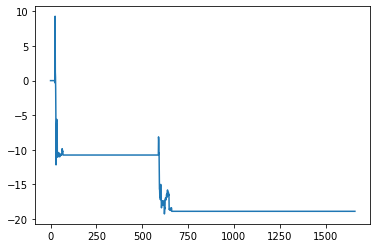

In [10]:
################################################################################
############################# Test Trading Environment ##############################
################################################################################
'''
market closeでそもそもかなり小さなsizeの時にその10%のorder出せるのがOKかは微妙。一定以下の保有になるexit orderの場合はfull exit扱いにしたほうがいい。

・ランダムアクションのトレードを行いエラーが発生しないこと
・pt, lcが正常に機能すること
・market close orderが正常に機能すること
'''
is_done_pnl_ratio = 0.01
is_done_no_holding_period = 1000
order_distribution_num = 10
market_order_fee = 0.006
limit_order_fee = 0.001
state_length = 120
start_ind = 1000000


env = AccountEnv(1, is_done_pnl_ratio, is_done_no_holding_period, order_distribution_num, market_order_fee, limit_order_fee, state_length)
env.reset()
for i in range(5000):
    action = list(env.action_space_sample())
    if action[0] == 5 or action[0] == 6:
        action[0] = 0
    ohlc = MarketData.get_ohlc(i + start_ind)
    #int action, int order_dist_type, double order_price_start_ratio, double order_price_width_ratio, double pt_price_start_ratio, double pt_price_width_ratio, int num_pt_div, double lc_ratio, double market_close_ratio, list ohlc_t1
    state, reward, is_done, _ = env.step(action[0], action[1], action[2], action[3], action[4], action[5], action[6], action[7], action[8], ohlc)
    if env.holding_side !=0:
        print('i=',i, 'p=',ohlc[-1], 'holding side=', env.holding_side, ', holding size=', env.holding_size, ', holding price=', env.holding_price, ', pnl=', env.total_pnl, ', num trade=', env.num_trade, ', win rate=', env.win_rate, ', reward=',reward)
    if is_done:
        print('i=',i, ', done')
        break
print('total pnl=', env.total_pnl, 'num trade=', env.num_trade, ', win rate=', env.win_rate)
plt.plot(env.log_total_pnl)

In [11]:

################################################################################
################################ Replay Memory #################################
################################################################################
class ReplayMemory:
    global Transition
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
        self.Transition = namedtuple('Transition', (
            'market_data',
            'state',
            'next_state',
             'action',
             'reward',
             'is_done'))

    def push(self, *args):
        self.memory.append(self.Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def get_len(self):
        return len(self.memory)

In [12]:
################################################################################
################################ network #################################
################################################################################



def init_weights(layer, activation_fn):
    """
    レイヤーごとに適切な初期化方法を選択し、重みとバイアスを初期化する関数。
    layer: 初期化するレイヤー
    activation_fn: レイヤーに適用される活性化関数
    """
    if isinstance(layer, nn.Linear):
        if activation_fn is None:
            init.xavier_uniform_(layer.weight, gain=init.calculate_gain('linear'))
        elif activation_fn == nn.ReLU:
            init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        elif activation_fn == nn.Hardsigmoid:
            init.kaiming_uniform_(layer.weight, nonlinearity='linear')
        elif activation_fn == nn.Tanh:
            init.xavier_uniform_(layer.weight, gain=init.calculate_gain('tanh'))
        else:
            init.xavier_uniform_(layer.weight, gain=init.calculate_gain('linear'))
        
        layer.bias.data.zero_()
    elif isinstance(layer, nn.Conv2d):
        if activation_fn is None:
            init.kaiming_uniform_(layer.weight, nonlinearity='linear')
        elif activation_fn == nn.ReLU:
            init.kaiming_uniform_(layer.weight, nonlinearity='relu')
        elif activation_fn == nn.Hardsigmoid:
            init.kaiming_uniform_(layer.weight, nonlinearity='linear')
        elif activation_fn == nn.Tanh:
            init.xavier_uniform_(layer.weight, gain=init.calculate_gain('tanh'))
        else:
            init.xavier_uniform_(layer.weight, gain=init.calculate_gain('linear'))
        
        layer.bias.data.zero_()
    else:
        pass



class ActorModel(nn.Module):
    def __init__(self,
                 num_actions,
                 num_params,
                 md_short_length, 
                 md_mid1_length, 
                 md_mid2_length, 
                 md_long1_length, 
                 md_long2_length, 
                 md_rsi_length,
                 state_holding_buy_side_len, 
                 state_holding_sell_side_len, 
                 state_holding_size_percentage_len, 
                 state_buy_order_size_percentage_len,
                 state_sell_order_size_percentage_len,
                 state_pt_order_len,
                 state_lc_order_len,
                 state_buy_order_divergence_len,
                 state_sell_order_divergence_len,
                 state_pt_order_divergence_len,
                 state_lc_order_divergence_len,
                 state_cancel_buy_len,
                 state_cancel_sell_len,
                 state_cancel_pt_len,
                 state_cancel_lc_len,
                 state_market_close_len,
                 state_unrealized_pnl_len):
        super(ActorModel, self).__init__()
        self.num_md_concat = md_short_length+md_mid1_length+md_mid2_length+md_long1_length+md_long2_length+md_rsi_length
        self.num_s_concat = state_holding_buy_side_len+state_holding_sell_side_len+state_holding_size_percentage_len+state_buy_order_size_percentage_len+\
        state_sell_order_size_percentage_len+state_pt_order_len+state_lc_order_len+state_buy_order_divergence_len+state_sell_order_divergence_len+\
        state_pt_order_divergence_len+state_lc_order_divergence_len+state_cancel_buy_len+state_cancel_sell_len+state_cancel_pt_len+state_cancel_lc_len+\
        state_market_close_len+state_unrealized_pnl_len
        self.md1 = nn.Linear(md_short_length, md_short_length)
        self.md2 = nn.Linear(md_mid1_length, md_mid1_length)
        self.md3 = nn.Linear(md_mid2_length, md_mid2_length)
        self.md4 = nn.Linear(md_long1_length, md_long1_length)
        self.md5 = nn.Linear(md_long2_length, md_long2_length)
        self.md6 = nn.Linear(md_rsi_length, md_rsi_length)
        self.s1 = nn.Linear(state_holding_buy_side_len, state_holding_buy_side_len)
        self.s2 = nn.Linear(state_holding_sell_side_len, state_holding_sell_side_len)
        self.s3 = nn.Linear(state_holding_size_percentage_len, state_holding_size_percentage_len)
        self.s4 = nn.Linear(state_buy_order_size_percentage_len, state_buy_order_size_percentage_len)
        self.s5 = nn.Linear(state_sell_order_size_percentage_len, state_sell_order_size_percentage_len)
        self.s6 = nn.Linear(state_pt_order_len, state_pt_order_len)
        self.s7 = nn.Linear(state_lc_order_len, state_lc_order_len)
        self.s8 = nn.Linear(state_buy_order_divergence_len, state_buy_order_divergence_len)
        self.s9 = nn.Linear(state_sell_order_divergence_len, state_sell_order_divergence_len)
        self.s10 = nn.Linear(state_pt_order_divergence_len, state_pt_order_divergence_len)
        self.s11 = nn.Linear(state_lc_order_divergence_len, state_lc_order_divergence_len)
        self.s12 = nn.Linear(state_cancel_buy_len, state_cancel_buy_len)
        self.s13 = nn.Linear(state_cancel_sell_len, state_cancel_sell_len)
        self.s14 = nn.Linear(state_cancel_pt_len, state_cancel_pt_len)
        self.s15 = nn.Linear(state_cancel_lc_len, state_cancel_lc_len)
        self.s16 = nn.Linear(state_market_close_len, state_market_close_len)
        self.s17 = nn.Linear(state_unrealized_pnl_len, state_unrealized_pnl_len)
        self.md_cat_linear = nn.Linear(self.num_md_concat, self.num_md_concat)
        self.s_cat_linear = nn.Linear(self.num_s_concat, self.num_s_concat)
        self.md_s_cat_linear = nn.Linear(self.num_md_concat + self.num_s_concat, self.num_md_concat + self.num_s_concat)
        self.buy = nn.Linear(self.num_md_concat + self.num_s_concat + state_holding_buy_side_len+state_buy_order_size_percentage_len+state_buy_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.sell = nn.Linear(self.num_md_concat + self.num_s_concat + state_holding_sell_side_len+state_sell_order_size_percentage_len+state_sell_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.pt = nn.Linear(self.num_md_concat + self.num_s_concat +state_pt_order_len+state_pt_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.lc = nn.Linear(self.num_md_concat + self.num_s_concat +state_lc_order_len+state_lc_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.cancel = nn.Linear(self.num_md_concat + self.num_s_concat +state_cancel_buy_len+state_cancel_sell_len+state_cancel_pt_len+state_cancel_lc_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.market_close = nn.Linear(self.num_md_concat + self.num_s_concat +state_market_close_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.final_action_ind = nn.Linear(state_holding_buy_side_len * 6, num_actions)
        self.action_ind_con = nn.Linear(num_actions, state_holding_buy_side_len * 6) #just to reshape action ind response tensor to concatenate with md+state outputs
        self.action_para_hidden1 = nn.Linear(state_holding_buy_side_len * 12, state_holding_buy_side_len * 3)
        self.action_para_hidden2 = nn.Linear(state_holding_buy_side_len * 3, num_actions)
        self.final_return = nn.Linear(num_actions+num_actions, num_actions) #input action ind, action para, and then return outputs for inputs to critic nn
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                activation_fn = type(self.relu) if hasattr(self, 'relu') and m in [self.fc1, self.fc2] else None
                init_weights(m, activation_fn)


    def forward(self, 
                batch_size,
                md_short, 
                 md_mid1, 
                 md_mid2, 
                 md_long1, 
                 md_long2, 
                 md_rsi,
                 state_holding_buy_side, 
                 state_holding_sell_side, 
                 state_holding_size_percentage, 
                 state_buy_order_size_percentage,
                 state_sell_order_size_percentage,
                 state_pt_order,
                 state_lc_order,
                 state_buy_order_divergence,
                 state_sell_order_divergence,
                 state_pt_order_divergence,
                 state_lc_order_divergence,
                 state_cancel_buy,
                 state_cancel_sell,
                 state_cancel_pt,
                 state_cancel_lc,
                 state_market_close,
                 state_unrealized_pnl):
        md_short_res = F.relu(self.md1(md_short))
        md_mid1_res = F.relu(self.md2(md_mid1))
        md_mid2_res = F.relu(self.md3(md_mid2))
        md_long1_res = F.relu(self.md4(md_long1))
        md_long2_res = F.relu(self.md5(md_long2))
        md_rsi_res = F.relu(self.md6(md_rsi))
        s1_res = F.relu(self.s1(state_holding_buy_side))
        s2_res = F.relu(self.s2(state_holding_sell_side))
        s3_res = F.relu(self.s3(state_holding_size_percentage))
        s4_res = F.relu(self.s4(state_buy_order_size_percentage))
        s5_res = F.relu(self.s5(state_sell_order_size_percentage))
        s6_res = F.relu(self.s6(state_pt_order))
        s7_res = F.relu(self.s7(state_lc_order))
        s8_res = F.relu(self.s8(state_buy_order_divergence))
        s9_res = F.relu(self.s9(state_sell_order_divergence))
        s10_res = F.relu(self.s10(state_pt_order_divergence))
        s11_res = F.relu(self.s11(state_lc_order_divergence))
        s12_res = F.relu(self.s12(state_cancel_buy))
        s13_res = F.relu(self.s13(state_cancel_sell))
        s14_res = F.relu(self.s14(state_cancel_pt))
        s15_res = F.relu(self.s15(state_cancel_lc))
        s16_res = F.relu(self.s16(state_market_close))
        s17_res = F.relu(self.s17(state_unrealized_pnl))
        #size(batch, data, data)を維持するためにdim=1
        md_cat = torch.cat([md_short_res, md_mid1_res, md_mid2_res, md_long1_res, md_long2_res, md_rsi_res], dim=1)
        s_cat = torch.cat([s1_res, s2_res, s3_res, s4_res, s5_res, s6_res, s7_res, s8_res, s9_res, s10_res, s11_res,
                                  s12_res, s13_res, s14_res, s15_res, s16_res, s17_res], dim=1)
        md_cat = F.relu(self.md_cat_linear(md_cat))
        s_cat = F.relu(self.s_cat_linear(s_cat))
        md_s_cat = torch.cat([md_cat, s_cat], dim=1)
        md_s_cat = F.relu(self.md_s_cat_linear(md_s_cat))

        buy_cat = torch.cat([md_s_cat, s1_res, s4_res, s8_res, s17_res], dim=1)
        sell_cat = torch.cat([md_s_cat, s2_res, s5_res, s9_res, s17_res], dim=1)
        pt_cat = torch.cat([md_s_cat, s6_res, s10_res, s17_res], dim=1)
        lc_cat = torch.cat([md_s_cat, s7_res, s11_res, s17_res], dim=1)
        cancel_cat = torch.cat([md_s_cat, s12_res, s13_res, s14_res, s15_res, s17_res], dim=1)
        market_close_cat = torch.cat([md_s_cat, s16_res, s17_res], dim=1)

        buy = F.relu(self.buy(buy_cat))
        sell = F.relu(self.sell(sell_cat))
        pt = F.relu(self.pt(pt_cat))
        lc = F.relu(self.lc(lc_cat))
        cancel = F.relu(self.cancel(cancel_cat))
        market_close = F.relu(self.market_close(market_close_cat))
        actions = torch.cat([buy, sell, pt, lc, cancel, market_close], dim=1)
        action_ind = F.softmax(self.final_action_ind(actions))
        action_ind_reshaped = F.relu(self.action_ind_con(action_ind))
        #print(actions.shape) = (bacth, 720)
        #print(action_ind.shape) = (bacth, 11)
        para_input_cat = torch.cat([actions, action_ind_reshaped], dim=1)
        action_para = F.relu(self.action_para_hidden1(para_input_cat))
        action_para = F.hardsigmoid(self.action_para_hidden2(action_para))
        action_ind_para_cat = torch.cat([action_ind, action_para], dim=1)
        final_return = self.final_return(action_ind_para_cat)
        return action_ind, action_para, final_return

    

    
class CriticModel(nn.Module):
    def __init__(self,
                 num_actions, #final_return from Actor
                 md_short_length, 
                 md_mid1_length, 
                 md_mid2_length, 
                 md_long1_length, 
                 md_long2_length, 
                 md_rsi_length,
                 state_holding_buy_side_len, 
                 state_holding_sell_side_len, 
                 state_holding_size_percentage_len, 
                 state_buy_order_size_percentage_len,
                 state_sell_order_size_percentage_len,
                 state_pt_order_len,
                 state_lc_order_len,
                 state_buy_order_divergence_len,
                 state_sell_order_divergence_len,
                 state_pt_order_divergence_len,
                 state_lc_order_divergence_len,
                 state_cancel_buy_len,
                 state_cancel_sell_len,
                 state_cancel_pt_len,
                 state_cancel_lc_len,
                 state_market_close_len,
                 state_unrealized_pnl_len):
        super(CriticModel, self).__init__()
        self.num_md_concat = md_short_length+md_mid1_length+md_mid2_length+md_long1_length+md_long2_length+md_rsi_length
        self.num_s_concat = state_holding_buy_side_len+state_holding_sell_side_len+state_holding_size_percentage_len+state_buy_order_size_percentage_len+\
        state_sell_order_size_percentage_len+state_pt_order_len+state_lc_order_len+state_buy_order_divergence_len+state_sell_order_divergence_len+\
        state_pt_order_divergence_len+state_lc_order_divergence_len+state_cancel_buy_len+state_cancel_sell_len+state_cancel_pt_len+state_cancel_lc_len+\
        state_market_close_len+state_unrealized_pnl_len
        self.action = nn.Linear(num_actions, state_holding_buy_side_len)
        self.md1 = nn.Linear(md_short_length, md_short_length)
        self.md2 = nn.Linear(md_mid1_length, md_mid1_length)
        self.md3 = nn.Linear(md_mid2_length, md_mid2_length)
        self.md4 = nn.Linear(md_long1_length, md_long1_length)
        self.md5 = nn.Linear(md_long2_length, md_long2_length)
        self.md6 = nn.Linear(md_rsi_length, md_rsi_length)
        self.s1 = nn.Linear(state_holding_buy_side_len, state_holding_buy_side_len)
        self.s2 = nn.Linear(state_holding_sell_side_len, state_holding_sell_side_len)
        self.s3 = nn.Linear(state_holding_size_percentage_len, state_holding_size_percentage_len)
        self.s4 = nn.Linear(state_buy_order_size_percentage_len, state_buy_order_size_percentage_len)
        self.s5 = nn.Linear(state_sell_order_size_percentage_len, state_sell_order_size_percentage_len)
        self.s6 = nn.Linear(state_pt_order_len, state_pt_order_len)
        self.s7 = nn.Linear(state_lc_order_len, state_lc_order_len)
        self.s8 = nn.Linear(state_buy_order_divergence_len, state_buy_order_divergence_len)
        self.s9 = nn.Linear(state_sell_order_divergence_len, state_sell_order_divergence_len)
        self.s10 = nn.Linear(state_pt_order_divergence_len, state_pt_order_divergence_len)
        self.s11 = nn.Linear(state_lc_order_divergence_len, state_lc_order_divergence_len)
        self.s12 = nn.Linear(state_cancel_buy_len, state_cancel_buy_len)
        self.s13 = nn.Linear(state_cancel_sell_len, state_cancel_sell_len)
        self.s14 = nn.Linear(state_cancel_pt_len, state_cancel_pt_len)
        self.s15 = nn.Linear(state_cancel_lc_len, state_cancel_lc_len)
        self.s16 = nn.Linear(state_market_close_len, state_market_close_len)
        self.s17 = nn.Linear(state_unrealized_pnl_len, state_unrealized_pnl_len)
        self.md_cat_linear = nn.Linear(self.num_md_concat, self.num_md_concat)
        self.s_cat_linear = nn.Linear(self.num_s_concat, self.num_s_concat)
        self.md_s_cat_linear = nn.Linear(self.num_md_concat + self.num_s_concat, self.num_md_concat + self.num_s_concat)
        self.buy = nn.Linear(self.num_md_concat + self.num_s_concat + state_holding_buy_side_len+state_buy_order_size_percentage_len+state_buy_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.sell = nn.Linear(self.num_md_concat + self.num_s_concat + state_holding_sell_side_len+state_sell_order_size_percentage_len+state_sell_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.pt = nn.Linear(self.num_md_concat + self.num_s_concat +state_pt_order_len+state_pt_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.lc = nn.Linear(self.num_md_concat + self.num_s_concat +state_lc_order_len+state_lc_order_divergence_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.cancel = nn.Linear(self.num_md_concat + self.num_s_concat +state_cancel_buy_len+state_cancel_sell_len+state_cancel_pt_len+state_cancel_lc_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.market_close = nn.Linear(self.num_md_concat + self.num_s_concat +state_market_close_len+state_unrealized_pnl_len, state_holding_buy_side_len)
        self.reshape_md_state = nn.Linear(state_holding_buy_side_len * 6, state_holding_buy_side_len * 3)
        self.reshape_md_state2 = nn.Linear(state_holding_buy_side_len * 3, num_actions)
        self.final_Q1 = nn.Linear(num_actions * 2, 1)
        self.final_Q2 = nn.Linear(num_actions * 2, 1)
        self.init_weights()
    
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                activation_fn = type(self.relu) if hasattr(self, 'relu') and m in [self.fc1, self.fc2] else None
                init_weights(m, activation_fn)

    def forward(self, 
                batch_size,
                actor_output,
                md_short, 
                 md_mid1, 
                 md_mid2, 
                 md_long1, 
                 md_long2, 
                 md_rsi,
                 state_holding_buy_side, 
                 state_holding_sell_side, 
                 state_holding_size_percentage, 
                 state_buy_order_size_percentage,
                 state_sell_order_size_percentage,
                 state_pt_order,
                 state_lc_order,
                 state_buy_order_divergence,
                 state_sell_order_divergence,
                 state_pt_order_divergence,
                 state_lc_order_divergence,
                 state_cancel_buy,
                 state_cancel_sell,
                 state_cancel_pt,
                 state_cancel_lc,
                 state_market_close,
                 state_unrealized_pnl):
        md_short_res = F.relu(self.md1(md_short))
        md_mid1_res = F.relu(self.md2(md_mid1))
        md_mid2_res = F.relu(self.md3(md_mid2))
        md_long1_res = F.relu(self.md4(md_long1))
        md_long2_res = F.relu(self.md5(md_long2))
        md_rsi_res = F.relu(self.md6(md_rsi))
        s1_res = F.relu(self.s1(state_holding_buy_side))
        s2_res = F.relu(self.s2(state_holding_sell_side))
        s3_res = F.relu(self.s3(state_holding_size_percentage))
        s4_res = F.relu(self.s4(state_buy_order_size_percentage))
        s5_res = F.relu(self.s5(state_sell_order_size_percentage))
        s6_res = F.relu(self.s6(state_pt_order))
        s7_res = F.relu(self.s7(state_lc_order))
        s8_res = F.relu(self.s8(state_buy_order_divergence))
        s9_res = F.relu(self.s9(state_sell_order_divergence))
        s10_res = F.relu(self.s10(state_pt_order_divergence))
        s11_res = F.relu(self.s11(state_lc_order_divergence))
        s12_res = F.relu(self.s12(state_cancel_buy))
        s13_res = F.relu(self.s13(state_cancel_sell))
        s14_res = F.relu(self.s14(state_cancel_pt))
        s15_res = F.relu(self.s15(state_cancel_lc))
        s16_res = F.relu(self.s16(state_market_close))
        s17_res = F.relu(self.s17(state_unrealized_pnl))
        #size(batch, data, data)を維持するためにdim=1
        md_cat = torch.cat([md_short_res, md_mid1_res, md_mid2_res, md_long1_res, md_long2_res, md_rsi_res], dim=1)
        s_cat = torch.cat([s1_res, s2_res, s3_res, s4_res, s5_res, s6_res, s7_res, s8_res, s9_res, s10_res, s11_res,
                                  s12_res, s13_res, s14_res, s15_res, s16_res, s17_res], dim=1)
        md_cat = F.relu(self.md_cat_linear(md_cat))
        s_cat = F.relu(self.s_cat_linear(s_cat))
        md_s_cat = torch.cat([md_cat, s_cat], dim=1)
        md_s_cat = F.relu(self.md_s_cat_linear(md_s_cat))
        buy_cat = torch.cat([md_s_cat, s1_res, s4_res, s8_res, s17_res], dim=1)
        sell_cat = torch.cat([md_s_cat, s2_res, s5_res, s9_res, s17_res], dim=1)
        pt_cat = torch.cat([md_s_cat, s6_res, s10_res, s17_res], dim=1)
        lc_cat = torch.cat([md_s_cat, s7_res, s11_res, s17_res], dim=1)
        cancel_cat = torch.cat([md_s_cat, s12_res, s13_res, s14_res, s15_res, s17_res], dim=1)
        market_close_cat = torch.cat([md_s_cat, s16_res, s17_res], dim=1)
        buy = F.relu(self.buy(buy_cat))
        sell = F.relu(self.sell(sell_cat))
        pt = F.relu(self.pt(pt_cat))
        lc = F.relu(self.lc(lc_cat))
        cancel = F.relu(self.cancel(cancel_cat))
        market_close = F.relu(self.market_close(market_close_cat))
        actions = torch.cat([buy, sell, pt, lc, cancel, market_close], dim=1)
        reshaped_md_states = F.relu(self.reshape_md_state(actions))
        reshaped_md_states = F.relu(self.reshape_md_state2(reshaped_md_states))
        final_input_cat = torch.cat([reshaped_md_states, actor_output], dim=1)
        Q1 = self.final_Q1(final_input_cat)
        Q2 = self.final_Q2(final_input_cat)
        return Q1, Q2


i= 22 p= 34218.0 holding side= -1 , holding size= 0.2997 , holding price= 34069.348485151815 , pnl= -54.76144274100101 , num trade= 0 , win rate= 0.0 , reward= -0.1
i= 23 p= 34189.0 holding side= -1 , holding size= 0.2997 , holding price= 34069.348485151815 , pnl= -46.070142741001014 , num trade= 0 , win rate= 0.0 , reward= 0.1
i= 24 p= 34042.0 holding side= -1 , holding size= 0.2997 , holding price= 34069.348485151815 , pnl= -2.014242741001013 , num trade= 0 , win rate= 0.0 , reward= -0.1
i= 25 p= 34190.0 holding side= -1 , holding size= 0.2997 , holding price= 34069.348485151815 , pnl= -46.369842741001015 , num trade= 0 , win rate= 0.0 , reward= -0.1
i= 26 p= 34203.0 holding side= -1 , holding size= 0.2997 , holding price= 34069.348485151815 , pnl= -50.26594274100101 , num trade= 0 , win rate= 0.0 , reward= 0.1
i= 27 p= 34263.0 holding side= -1 , holding size= 0.2997 , holding price= 34069.348485151815 , pnl= -68.24794274100103 , num trade= 0 , win rate= 0.0 , reward= 0.1
i= 28 p= 34

<ipython-input-13-00df9e651d47>:83: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  md = torch.tensor(res[0])
<ipython-input-12-d602cef551b2>:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_ind = F.softmax(self.final_action_ind(actions))


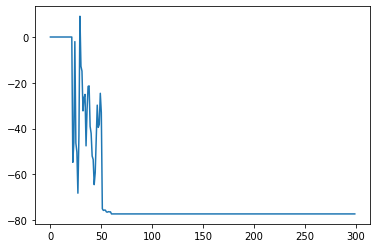

In [13]:
################################################################################
################################ Main DQN #################################
################################################################################
'''
・layernorm, dropout, 出力のsoftmaxなどを試す

1. 初期化
2. replay memory溜まるまで
'''
rm = ReplayMemory(100000)

#params for Env
is_done_pnl_ratio = 0.1
is_done_no_holding_period = 3000
order_distribution_num = 10
market_order_fee = 0.006
limit_order_fee = 0.001
state_length = 120
start_ind = 1000000
#Params for MarketData
nn_input_length = 120
short_length = 120
mid1_length = 720
mid2_length = 4800
long1_length = 12000
long2_length = 48000
#params for NN
num_actions = 11
num_action_params = 2
#initialize Env
env = AccountEnv(0, is_done_pnl_ratio, is_done_no_holding_period, order_distribution_num, market_order_fee, limit_order_fee, state_length)
state, reward, is_done = env.reset()
state_length = env.get_state_length()[0]
next_state = state
#initialize MarketData Wrapper
mdnw = MarketDataNNWrapper()
md_close = np.array(MarketData.logclose)
rsi = MarketData.rsi
md_length = mdnw.get_nn_input_length(md_close, rsi, 1000000, nn_input_length, short_length, mid1_length, mid2_length, long1_length, long2_length)
#initialize NN
actor_nn = ActorModel(
    num_actions, num_action_params,
    md_length['short_length'], md_length['mid1_length'], md_length['mid2_length'], md_length['long1_length'], md_length['long1_length'], md_length['rsi_length'],
    state_length['state_holding_buy_side'], state_length['state_holding_sell_side'], state_length['state_holding_size_percentage'], state_length['state_buy_order_size_percentage'],
    state_length['state_sell_order_size_percentage'], state_length['state_pt_order'], state_length['state_lc_order'], state_length['state_buy_order_divergence'], 
    state_length['state_sell_order_divergence'], state_length['state_pt_order_divergence'], state_length['state_lc_order_divergence'], state_length['state_cancel_buy'], 
    state_length['state_cancel_sell'], state_length['state_cancel_pt'], state_length['state_cancel_lc'], state_length['state_market_close'], state_length['state_unrealized_pnl']
    ).double() #floatでもいいかも、そっちの方が処理が早いはず
critic_nn = CriticModel(
    num_actions,
    md_length['short_length'], md_length['mid1_length'], md_length['mid2_length'], md_length['long1_length'], md_length['long1_length'], md_length['rsi_length'],
    state_length['state_holding_buy_side'], state_length['state_holding_sell_side'], state_length['state_holding_size_percentage'], state_length['state_buy_order_size_percentage'],
    state_length['state_sell_order_size_percentage'], state_length['state_pt_order'], state_length['state_lc_order'], state_length['state_buy_order_divergence'], 
    state_length['state_sell_order_divergence'], state_length['state_pt_order_divergence'], state_length['state_lc_order_divergence'], state_length['state_cancel_buy'], 
    state_length['state_cancel_sell'], state_length['state_cancel_pt'], state_length['state_cancel_lc'], state_length['state_market_close'], state_length['state_unrealized_pnl']
    ).double() #floatでもいいかも、そっちの方が処理が早いはず

for i in range(300):
    action = list(env.action_space_sample())
    if action[0] == 5 or action[0] == 6:
        action[0] = 0
    ohlc_t1 = MarketData.get_ohlc(i + start_ind+1)
    #int action, int order_dist_type, double order_price_start_ratio, double order_price_width_ratio, double pt_price_start_ratio, double pt_price_width_ratio, int num_pt_div, double lc_ratio, double market_close_ratio, list ohlc_t1
    next_state, reward, is_done, _ = env.step(action[0], action[1], action[2], action[3], action[4], action[5], action[6], action[7], action[8], ohlc_t1)
    md = mdnw.get_nn_input(md_close, rsi, i+start_ind, nn_input_length, short_length, mid1_length, mid2_length, long1_length, long2_length)
    #md = [torch.tensor(x, dtype=torch.float) for x in market_data]
    #state = [torch.tensor(x, dtype=torch.float) for x in state]
    #rm.push(md[0], md[1], md[2], md[3], md[4], md[5], s[0], s[1], s[2], s[3], s[4], s[5], s[6], s[7], s[8], s[9], s[10], s[11], s[12], s[13], s[14], s[15], s[16], action, reward)
    rm.push(md, state, next_state, action, reward, is_done)
    state = next_state
    if env.holding_side !=0:
        print('i=',i, 'p=',ohlc_t1[-1], 'holding side=', env.holding_side, ', holding size=', env.holding_size, ', holding price=', env.holding_price, ', pnl=', env.total_pnl, ', num trade=', env.num_trade, ', win rate=', env.win_rate, ', reward=',reward)
    if is_done:
        print('i=',i, ', done')
        break
print('total pnl=', env.total_pnl, 'num trade=', env.num_trade, ', win rate=', env.win_rate)
plt.plot(env.log_total_pnl)

#do feed forward calc for batch selected data
batch_size = 10
batches = rm.sample(batch_size)
res = list(zip(*batches))
md = torch.tensor(res[0])
md = md.transpose(0,1)
state = torch.tensor(res[1])
state = state.transpose(0,1)
action_ind, action_para, final_return = actor_nn(batch_size, 
                   md[0], md[1], md[2], md[3], md[4], md[5], 
                   state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])

print(final_return.shape)
q1, q2 = critic_nn(batch_size, final_return, 
                   md[0], md[1], md[2], md[3], md[4], md[5], 
                   state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])


#print('action_ind: ', action_ind)
#print('action_para: ', action_para)
#print('q1:', q1)
#print('q2:', q2)


#calc loss
# Qを計算 : reward if done else (reward + gamma * n_qval)







In [67]:
ohlc_t1 = MarketData.get_ohlc(100000)
state, reward, is_done, _ = env.step(0, 0, 0, 0, 0, 0, 0, 0, 0, ohlc_t1)
md = mdnw.get_nn_input(md_close, rsi, 100000, nn_input_length, short_length, mid1_length, mid2_length, long1_length, long2_length)
md = torch.tensor(md)[:,None]
state = torch.tensor(state)[:,None]
action_ind, action_para, final_return = actor_nn(1, 
                   md[0], md[1], md[2], md[3], md[4], md[5], 
                   state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
print(action_ind)
print(action_para)

tensor([[0.2515, 0.0134, 0.0123, 0.0172, 0.1438, 0.4135, 0.0074, 0.0660, 0.0274,
         0.0017, 0.0457]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)
tensor([[0.3621, 0.4143, 0.3621, 0.7589, 0.4743, 0.6097, 0.3521, 0.5561, 0.1944,
         0.9735, 0.1537]], dtype=torch.float64, grad_fn=<HardsigmoidBackward0>)


<ipython-input-30-d602cef551b2>:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_ind = F.softmax(self.final_action_ind(actions))


In [65]:
batches = rm.sample(1)
res = list(zip(*batches))
md = torch.tensor(res[0])
md = md.transpose(0,1)
state = torch.tensor(res[1])
state = state.transpose(0,1)
print(md.shape)

torch.Size([6, 1, 120])


In [105]:
'''
0:None
1   - 45: buy
46 -90: sell
91-185: pt
186 - 280: lc
281: cancel buy
282: cancel sell
283: cancel pt
284: cancel lc
285: cancel all orders
286 - 295: market exit (10% - 100%)




#action = 0:nothing, 1:buy, 2:sell, 3:pt, 4:lc, 5:cancel buy, 6:cancel sell, 7:cancel pt, 8:cancel lc, 9:cancel all, 10: market close (percentage)

1. action,
2. order_dist_type,
3. order_price_start_ratio,
4. order_price_width_ratio,
5. pt_price_start_ratio,
6. pt_price_width_ratio,
7. num_pt_div,
8. lc_ratio,
9. market_close_ratio,
'''
'''
def get_action_params(max_output_unit:int):
    num_action_params = 9
    order_start_ratio = [random.randint(5, 20) / 1000.0, random.randint(20, 35) / 1000.0, random.randint(35, 50) / 1000.0]
    order_width_ratio = [random.randint(5, 20) / 1000.0, random.randint(20, 35) / 1000.0, random.randint(35, 50) / 1000.0]
    order_dist_type = [0,1,2,3,4]
    pt_start_ratio =  list(np.round(np.arange(0.01, 0.105, 0.005), 4))
    pt_width_ratio =  list(np.round(np.arange(0.01, 0.06, 0.01), 4))
    order_param_combinations = list(itertools.product(order_dist_type, order_start_ratio, order_width_ratio))
    pt_combinations = list(itertools.product(pt_start_ratio, pt_width_ratio))
    market_close_percentage =  list(np.round(np.arange(0.1, 1.01, 0.1), 4))

    print('order_param_combinations=',len(order_param_combinations))
    print('pt_combinations=',len(pt_combinations))
    print('market_close_percentage=',len(market_close_percentage))

    pt_start_ind = len(order_param_combinations)*2 + 1
    lc_start_ind = len(order_param_combinations)*2 + len(pt_combinations) + 1
    market_close_start_ind = len(order_param_combinations)*2 + len(pt_combinations)*2 + 6

    if max_output_unit == 0: #no action
        return [0] * num_action_params
    elif max_output_unit <=len(order_param_combinations): #buy
        action = [1]
        action.extend(order_param_combinations[max_output_unit-1])
        action.extend([0]* (num_action_params - 4))
        return action
    elif max_output_unit <= len(order_param_combinations)*2: #sell
        action = [2]
        action.extend(order_param_combinations[max_output_unit-len(order_param_combinations)-1])
        action.extend([0]* (num_action_params - 4))
        return action
    elif max_output_unit <= len(order_param_combinations)*2 + len(pt_combinations): #pt order
        action = [3, 0, 0, 0, pt_combinations[max_output_unit - pt_start_ind][0], pt_combinations[max_output_unit - pt_start_ind][1], 0, 0, 0]
        return action
    elif max_output_unit <= len(order_param_combinations)*2 + len(pt_combinations)*2: #lc order
        action = [4, 0, 0, 0, pt_combinations[max_output_unit - lc_start_ind][0], pt_combinations[max_output_unit - lc_start_ind][1], 0, 0, 0]
        return action    
    elif max_output_unit == len(order_param_combinations)*2 + len(pt_combinations)*2 + 1: #cancel buy
        action = [5]
        action.extend([0]* (num_action_params-1))
        return action
    elif max_output_unit == len(order_param_combinations)*2 + len(pt_combinations)*2 + 2: #cancel sell
        action = [6]
        action.extend([0]* (num_action_params-1))
        return action
    elif max_output_unit == len(order_param_combinations)*2 + len(pt_combinations)*2 + 3: #cancel pt
        action = [7]
        action.extend([0]* (num_action_params-1))
        return action
    elif max_output_unit == len(order_param_combinations)*2 + len(pt_combinations)*2 + 4: #cancel lc
        action = [8]
        action.extend([0]* (num_action_params-1))
        return action
    elif max_output_unit == len(order_param_combinations)*2 + len(pt_combinations)*2 + 5: #cancel all 
        action = [9]
        action.extend([0]* (num_action_params-1))
        return action
    elif max_output_unit <= len(order_param_combinations)*2 + len(pt_combinations)*2 + 5 + len(market_close_percentage): #market close
        action = [10]
        action.extend([0]* (num_action_params-2))
        actiin = action.append(market_close_percentage[max_output_unit - market_close_start_ind])
        return action
    else:
        print('Invalid input for get action param !', max_output_unit)
        return [0] * num_action_params
    
    

get_action_params(290)
'''

"\ndef get_action_params(max_output_unit:int):\n    num_action_params = 9\n    order_start_ratio = [random.randint(5, 20) / 1000.0, random.randint(20, 35) / 1000.0, random.randint(35, 50) / 1000.0]\n    order_width_ratio = [random.randint(5, 20) / 1000.0, random.randint(20, 35) / 1000.0, random.randint(35, 50) / 1000.0]\n    order_dist_type = [0,1,2,3,4]\n    pt_start_ratio =  list(np.round(np.arange(0.01, 0.105, 0.005), 4))\n    pt_width_ratio =  list(np.round(np.arange(0.01, 0.06, 0.01), 4))\n    order_param_combinations = list(itertools.product(order_dist_type, order_start_ratio, order_width_ratio))\n    pt_combinations = list(itertools.product(pt_start_ratio, pt_width_ratio))\n    market_close_percentage =  list(np.round(np.arange(0.1, 1.01, 0.1), 4))\n\n    print('order_param_combinations=',len(order_param_combinations))\n    print('pt_combinations=',len(pt_combinations))\n    print('market_close_percentage=',len(market_close_percentage))\n\n    pt_start_ind = len(order_param_comb

In [ ]:
'''
start_ratio = 0.01 - 0.1
width_ratio = 0.01 - 0.1
100ユニットだと組み合わせ的には10 x 10
start_ratioとwidth_ratioを掛け合わせた数値の小さい順に並べて1-100の該当するindexで取得できるようにする。
0:nothing, 1:buy, 2:sell, 3:pt, 4:lc, 5:cancel buy, 6:cancel sell, 7:cancel pt, 8:cancel lc, 9:cancel all, 10: market close (percentage)
'''
'''
class NNActionConverter:
    def __init__(self, from_start_ratio:float, to_start_ratio:float, from_width_ratio:float, to_width_ratio:float, 
                 from_pt_start_ratio:float, to_pt_start_ratio:float, from_pt_width_ratio:float, to_pt_width_ratio:float, 
                 from_lc_ratio:float, to_lc_ratio:float, num_order_param_splits:int, num_param_units:int):
        self.order_params = self.__get_sorted_start_width_combinations(from_start_ratio, to_start_ratio, from_width_ratio, to_width_ratio, num_order_param_splits)
        self.pt_params = self.__get_sorted_start_width_combinations(from_pt_start_ratio, to_pt_start_ratio, from_pt_width_ratio, to_pt_width_ratio, num_order_param_splits)
        self.lc_params = list(np.linspace(from_lc_ratio, to_lc_ratio, num_param_units))
        self.market_close_params = list(np.linspace(0.1, 1.0, num_param_units))
        self.action_ind_map = {1:self.order_params, 2:self.order_params, 3:self.pt_params, 4:self.lc_params, 10:self.market_close_params}
        if len(self.order_params) != num_param_units or len(self.pt_params) != num_param_units or len(self.lc_params) != num_param_units or len(self.market_close_params) != num_param_units:
            print('NNActionConverter-action param length invalid !')
            print('order_params=', len(self.order_params))
            print('pt_params=', len(self.pt_params))
            print('lc_params=', len(self.lc_params))
            print('market_close_params=', len(self.market_close_params))

    def __get_sorted_start_width_combinations(self, from_start_ratio:float, to_start_ratio:float, from_width_ratio:float, to_width_ratio:float, num_order_param_splits:int):
        s = np.round(np.linspace(from_start_ratio, to_start_ratio, num_order_param_splits), 4)
        w = np.round(np.linspace(from_width_ratio, to_width_ratio, num_order_param_splits), 4)
        sw = list(itertools.product(s, w))
        prod_val_list = [round(x[0] + x[1], 4) for x in sw]
        ind_dict = {}
        for i in range(len(prod_val_list)):
            ind_dict[i] = prod_val_list[i]
        ind_dict = sorted(ind_dict.items(), key=lambda x:x[1])
        order_param_combinations = []
        for i in range(len(ind_dict)):
            order_param_combinations.append(sw[ind_dict[i][0]])
        return order_param_combinations
    
    def get_action_params(self, action_ind, action_param_ind):
        return self.action_ind_map[action_ind][action_param_ind]

nac = NNActionConverter(0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 0.01, 0.1, 10, 100)
nac.get_action_params(1, 41)
'''

In [14]:
########################################################################################
######################################  ###########################################
########################################################################################
'''
paramは2unitにして、それぞれstart ratio, width ratioを0.01 - 0.1の範囲で0-1表現することにする。
market closeの場合は2つの出力の合計値0-2を0.1-1.0に正規化。order distは一様分布に固定。
NN出力はhardsigmoidで0-1の範囲にしておく。
order dist type=0 (uniform dist)は呼び出し側で決める。通常固定。
pt_divも10固定

0:nothing, 1:buy, 2:sell, 3:pt, 4:lc, 5:cancel buy, 6:cancel sell, 7:cancel pt, 8:cancel lc, 9:cancel all, 10: market close (percentage)
1. action,
2. order_dist_type,
3. order_price_start_ratio,
4. order_price_width_ratio,
5. pt_price_start_ratio,
6. pt_price_width_ratio,
7. num_pt_div,
8. lc_ratio,
9. market_close_ratio,
'''
class NNActionParamConverter:
    def __init__(self, num_actions:int):
        self.num_actions = num_actions
        self.min_num_order_div = 2
        self.max_num_order_div = 10
        self.min_order_price_start_ratio = 0.01
        self.max_order_price_start_ratio = 0.1
        self.min_order_width_start_ratio = 0.01
        self.max_order_width_start_ratio = 0.1
        self.min_pt_price_start_ratio = 0.01
        self.max_pt_price_start_ratio = 0.1
        self.min_pt_price_width_ratio = 0.01
        self.max_pt_price_width_ratio = 0.1
        self.min_lc_ratio = 0.005
        self.max_lc_ratio = 0.1
        self.min_market_close_ratio = 0.1
        self.max_market_close_ratio = 1.0
        self.pt_div = 10

    
    def get_action_for_env(self, action_ind:int, order_dist_type:int, nn_outputs:np.ndarray):
        if action_ind == 0:
            return [0] * self.num_actions
        elif action_ind <= 2: #buy / sell order
            order_start_ratio = round(self.__convert_range(nn_outputs[0], 0, 1, self.min_order_price_start_ratio, self.max_order_price_start_ratio), 4)
            order_width_ratio = round(self.__convert_range(nn_outputs[1], 0, 1, self.min_order_width_start_ratio, self.max_order_width_start_ratio), 4)
            return [action_ind, order_dist_type, order_start_ratio, order_width_ratio, 0, 0, 0, 0, 0]
        elif action_ind == 3: #pt order
            pt_start_ratio = round(self.__convert_range(nn_outputs[0], 0, 1, self.min_pt_price_start_ratio, self.max_pt_price_start_ratio), 4)
            pt_width_ratio = round(self.__convert_range(nn_outputs[1], 0, 1, self.min_pt_price_width_ratio, self.max_pt_price_width_ratio), 4)
            return [action_ind, order_dist_type, pt_start_ratio, pt_width_ratio, 0, 0, 0, 0, 0]
        elif action_ind == 4: #lc order
            lc_start_ratio = round(self.__convert_range(nn_outputs[0], 0, 1, self.min_lc_ratio, self.max_lc_ratio), 4)
            return [action_ind, 0, 0, 0, 0, 0, 0, lc_start_ratio, 0]
        elif action_ind == 5: #cancel buy
            return [action_ind, 0, 0, 0, 0, 0, 0, 0, 0]
        elif action_ind == 6: #cancel sell
            return [action_ind, 0, 0, 0, 0, 0, 0, 0, 0]
        elif action_ind == 7: #cancel pt
            return [action_ind, 0, 0, 0, 0, 0, 0, 0, 0]
        elif action_ind == 8: #cancel lc
            return [action_ind, 0, 0, 0, 0, 0, 0, 0, 0]
        elif action_ind == 9: #cancel all
            return [action_ind, 0, 0, 0, 0, 0, 0, 0, 0]
        elif action_ind == 10: #market close
            market_close_ratio = round(self.__convert_range(nn_outputs[0], 0, 1, self.min_market_close_ratio, self.max_market_close_ratio), 4)
            return [action_ind, 0, 0, 0, 0, 0, 0, 0, market_close_ratio]
        else:
            print('Invalid action ind !')
            print(action_ind)
        
    

    def __convert_range(self, value, min_val, max_val, new_min, new_max):
        """
        Convert a value from a range of [0,1] to a new range [new_min, new_max]
        """
        normalized_value = (value - min_val) / (max_val - min_val)
        new_value = new_min + normalized_value * (new_max - new_min)
        return new_value

napc = NNActionParamConverter(11)
napc.get_action_for_env(2, 0, np.array([0.2,0.2]))

[2, 0, 0.028, 0.028, 0, 0, 0, 0, 0]

In [ ]:
########################################################################################
###################################### DQN ###########################################
########################################################################################
class DDPG:
    def __init__(self, from_ind:int, to_ind:int):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print('device=', self.device)
        self.from_ind = from_ind
        self.to_ind = to_ind
        #params for Env
        self.memory_capacity = 300000
        self.rm = ReplayMemory(self.memory_capacity)
        self.is_done_pnl_ratio = 0.1
        self.is_done_no_holding_period = 3000
        self.order_distribution_num = 10
        self.market_order_fee = 0.006
        self.limit_order_fee = 0.001
        self.state_length = 120
        self.from_ind = from_ind
        self.to_ind = to_ind
        self.order_dist_type =0
        #Params for MarketData
        self.nn_input_length = 120
        self.short_length = 120
        self.mid1_length = 720
        self.mid2_length = 4800
        self.long1_length = 12000
        self.long2_length = 48000
        #params for NN
        self.num_actions = 11
        self.num_action_params = 2
        self.batch_size = 10000
        self.train_interval = 5000 #batch size分が溜まったらinterval step毎に学習を実施
        self.lr = 0.01
        self.gamma = 0.05
        self.tau = 0.01 #soft updateでモデルウェイトを更新する際に掛ける値
        self.epsilon = 0.7 #一定確率でランダムなアクションを選択する
        self.num_episode = 10000
        self.grad_clip_val = 100 #適当
        self.loss_func = nn.SmoothL1Loss()
        #initialize Environment
        env = AccountEnv(0, self.is_done_pnl_ratio, self.is_done_no_holding_period, self.order_distribution_num, self.market_order_fee, self.limit_order_fee, self.state_length)
        state, reward, is_done = env.reset()
        state_length = env.get_state_length()[0]
        next_state = state
        self.napc = NNActionParamConverter(self.num_actions)
        #initialize MarketData Wrapper
        self.mdnw = MarketDataNNWrapper()
        self.md_close = np.array(MarketData.logclose)
        self.md_rsi = MarketData.rsi
        md_length = mdnw.get_nn_input_length(md_close, rsi, 1000000, nn_input_length, short_length, mid1_length, mid2_length, long1_length, long2_length)
        #initialize NN 
        self.actor_nn = ActorModel(
            self.num_actions, self.num_action_params,
            md_length['short_length'], md_length['mid1_length'], md_length['mid2_length'], md_length['long1_length'], md_length['long1_length'], md_length['rsi_length'],
            state_length['state_holding_buy_side'], state_length['state_holding_sell_side'], state_length['state_holding_size_percentage'], state_length['state_buy_order_size_percentage'],
            state_length['state_sell_order_size_percentage'], state_length['state_pt_order'], state_length['state_lc_order'], state_length['state_buy_order_divergence'], 
            state_length['state_sell_order_divergence'], state_length['state_pt_order_divergence'], state_length['state_lc_order_divergence'], state_length['state_cancel_buy'], 
            state_length['state_cancel_sell'], state_length['state_cancel_pt'], state_length['state_cancel_lc'], state_length['state_market_close'], state_length['state_unrealized_pnl']
            ).double().to(self.device)
        self.critic_nn = CriticModel(
            self.num_actions,
            md_length['short_length'], md_length['mid1_length'], md_length['mid2_length'], md_length['long1_length'], md_length['long1_length'], md_length['rsi_length'],
            state_length['state_holding_buy_side'], state_length['state_holding_sell_side'], state_length['state_holding_size_percentage'], state_length['state_buy_order_size_percentage'],
            state_length['state_sell_order_size_percentage'], state_length['state_pt_order'], state_length['state_lc_order'], state_length['state_buy_order_divergence'], 
            state_length['state_sell_order_divergence'], state_length['state_pt_order_divergence'], state_length['state_lc_order_divergence'], state_length['state_cancel_buy'], 
            state_length['state_cancel_sell'], state_length['state_cancel_pt'], state_length['state_cancel_lc'], state_length['state_market_close'], state_length['state_unrealized_pnl']
            ).double().to(self.device)        
        #self.target_actor_nn.load_state_dict(self.actor_nn.state_dict())
        #self.target_critic_nn.load_state_dict(self.critic_nn.state_dict())
        self.target_actor_nn = copy.deepcopy(self.actor_nn)
        self.target_critic_nn = copy.deepcopy(self.critic_nn)
        self.actor_optimizer = torch.optim.Adam(self.actor_nn.parameters(), lr=1e-03)
        self.critic_optimizer = torch.optim.Adam(self.critic_nn.parameters(), lr=1e-03)


    '''
    only acceptable state, market data directly genected from env or marketdata, not allowed sample selected from replay memory
    '''
    def sample_action(self, state, market_data, training=False):
        stddev = 0.2
        md = torch.tensor(market_data)[:,None].to(self.device)
        state = torch.tensor(state)[:,None].to(self.device)
        action_ind, action_para, final_return = self.actor_nn(1, md[0], md[1], md[2], md[3], md[4], md[5], 
                                                              state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
        action_ind = action_ind[0].cpu().detach().numpy().copy() #cpuに渡さずにauto gradientだけoffにしてgpu上で処理した方がいいかも。
        action_para = action_para[0].cpu().detach().numpy().copy()
        if training:
            if self.epsilon <= random.random():
                action_noise = np.random.normal(1.0, stddev, size=len(action_ind))
                param_noise = np.random.normal(1.0, stddev, size=len(action_para))
                action_ind = np.clip(action_ind * action_noise, -1, 1)
                action_para = np.clip(action_para * param_noise, -1, 1)
            return self.napc.get_action_for_env(np.argmax(action_ind), self.order_dist_type, action_para)
        else:
            return self.napc.get_action_for_env(np.argmax(action_ind), self.order_dist_type, action_para)

    def soft_update(self, target, source, tau):
        """
        Copies the parameters from `source` network to `target` network, with soft updates controlled by the `tau` parameter.

        Args:
            target (torch.nn.Module): Target network to update.
            source (torch.nn.Module): Source network to copy the parameters from.
            tau (float): Interpolation parameter for soft parameter updates. 0 <= tau <= 1.

        Returns:
            None
        """
        with torch.no_grad():
            for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)


    '''
    target networkの出力を正しいものとして誤差を計算する。

    '''
    def train(self):
        # ランダムに経験を取得してバッチを作成
        batches = self.rm.sample(self.batch_size)
        res = list(zip(*batches))
        md = torch.tensor(res[0]).to(self.device)
        md = md.transpose(0,1)
        state = torch.tensor(res[1]).to(self.device)
        state = state.transpose(0,1)
        # Target Networkを用いて次の状態の価値を出す
        action_ind, action_para, final_return = self.target_actor_nn(self.batch_size, 
                                         md[0], md[1], md[2], md[3], md[4], md[5], 
                                         state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
        q1, q2 = self.target_critic_nn(self.batch_size, final_return, 
                   md[0], md[1], md[2], md[3], md[4], md[5], 
                   state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
        # Qを計算 : reward if done else (reward + gamma * n_qval)
        reward = np.array(res[4])
        is_done = np.array(res[5])
        q1 = q1.cpu().detach().numpy().copy()
        q2 = q2.cpu().detach().numpy().copy()
        min_qvals = np.array([min(a, b) for a, b in zip(q1, q2)]).flatten() # 2つのQ値から小さいほうを採用
        target_q = reward + self.gamma * min_qvals * (1 - is_done)
        #Criticの学習
        with torch.no_grad():
            q1, q2 = self.critic_nn(self.batch_size, final_return, 
                   md[0], md[1], md[2], md[3], md[4], md[5], 
                   state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
        #compute huber loss
        target_q = torch.tensor(target_q).reshape(-1,1).to(self.device)
        loss1 = self.loss_func(target_q, q1)
        loss2 = self.loss_func(target_q, q2)
        critic_loss = loss1.to(self.device) + loss2.to(self.device)
        critic_loss.requires_grad = True
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_value_(self.critic_nn.parameters(), self.grad_clip_val)
        self.critic_optimizer.step()
        #Actorの学習
        with torch.no_grad():
            action_ind, action_para, final_return = self.target_actor_nn(self.batch_size, 
                                                                         md[0], md[1], md[2], md[3], md[4], md[5], 
                                                                         state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
            q1, q2 = self.critic_nn(self.batch_size, final_return, 
                                    md[0], md[1], md[2], md[3], md[4], md[5], 
                                    state[0], state[1], state[2], state[3], state[4], state[5], state[6], state[7], state[8], state[9], state[10], state[11], state[12], state[13], state[14], state[15], state[16])
        actor_loss = -(q1+q2).mean()
        actor_loss = actor_loss.to(self.device)
        actor_loss.requires_grad = True
        # update networks
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        return actor_loss.cpu().detach().numpy().copy(), critic_loss.cpu().detach().numpy().copy()


    def main_loop(self):
        self.total_reward_log = []
        self.steps_log = []
        self.actor_loss_log = []
        self.critic_loss_log = []
        self.num_trade_log = []
        self.win_rate_log = []
        self.total_profit_log = []
        self.total_counter = 0
        self.num_trained = 0
        self.num_soft_updated = 0
        #torch.autograd.set_detect_anomaly(True)
        #self.pbar_for_replay_memory = tqdm(total=self.start_steps)
        print('started learning, collecting data for bacth size...')
        for episode in range(self.num_episode):
            num_steps = 0
            total_reward = 0
            env = AccountEnv(0, self.is_done_pnl_ratio, self.is_done_no_holding_period, self.order_distribution_num, self.market_order_fee, self.limit_order_fee, self.state_length)
            state, reward, is_done = env.reset()
            ohlc_t1 = MarketData.get_ohlc(self.from_ind)
            md = self.mdnw.get_nn_input(self.md_close, self.md_rsi, self.from_ind, self.nn_input_length, self.short_length, self.mid1_length, self.mid2_length, self.long1_length, self.long2_length)
            while is_done == 0:
                action = self.sample_action(state, md, True)
                ohlc_t1 = MarketData.get_ohlc(self.from_ind+num_steps+1)
                n_state, reward, is_done, _ = env.step(action[0], action[1], action[2], action[3], action[4], action[5], action[6], action[7], action[8], ohlc_t1)
                self.rm.push(md, state, n_state, action, reward, is_done)
                state = n_state
                total_reward += reward                
                num_steps += 1
                self.total_counter += 1
                md = self.mdnw.get_nn_input(self.md_close, self.md_rsi, self.from_ind + num_steps, self.nn_input_length, self.short_length, self.mid1_length, self.mid2_length, self.long1_length, self.long2_length)
                if self.to_ind <= self.from_ind + num_steps + 1:
                    is_done = 1
                elif self.rm.get_len() >= self.batch_size and self.total_counter % self.train_interval == 0: #batch size以上になったらtrain interval毎に学習実施
                    #print('training..')
                    actor_loss, critic_loss = self.train()
                    self.actor_loss_log.append(actor_loss.mean())
                    self.critic_loss_log.append(critic_loss.mean())
                    self.num_trained += 1
                    #soft update
                    #print('soft updating..')
                    self.soft_update( self.target_actor_nn, self.actor_nn, self.tau) #target_param = target_param * (1 - tau) + param * tau
                    self.soft_update( self.target_critic_nn,  self.critic_nn, self.tau) #target_param = target_param * (1 - tau) + param * tau
                    self.num_soft_updated += 1
            self.num_trade_log.append(env.num_trade)
            self.win_rate_log.append(env.win_rate)
            self.total_profit_log.append(env.total_pnl)
            self.total_reward_log.append(total_reward)
            self.steps_log.append(num_steps)
            print('#episode=', episode, ', num steps=', num_steps, ', num trained=', self.num_trained, ', ave actor loss=', np.mean(self.actor_loss_log), ', ave critic loss=', np.mean(self.critic_loss_log), ', total reward=', self.total_reward_log[-1], ', num trade=', env.num_trade, ', total pnl=', env.total_pnl)

ddpg = DDPG(500000, 1000000)
ddpg.main_loop()


device= cuda
started learning, collecting data for bacth size...


<ipython-input-12-d602cef551b2>:194: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_ind = F.softmax(self.final_action_ind(actions))
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#episode= 0 , num steps= 3000 , num trained= 0 , ave actor loss= nan , ave critic loss= nan , total reward= -274.799999999994
#episode= 1 , num steps= 3000 , num trained= 0 , ave actor loss= nan , ave critic loss= nan , total reward= -264.3999999999916
#episode= 2 , num steps= 3000 , num trained= 0 , ave actor loss= nan , ave critic loss= nan , total reward= -265.79999999999194
#episode= 3 , num steps= 3000 , num trained= 1 , ave actor loss= -0.7429438352633883 , ave critic loss= 0.2677469394902434 , total reward= -257.19999999999
#episode= 4 , num steps= 3000 , num trained= 2 , ave actor loss= -0.7418534044761542 , ave critic loss= 0.2677796813852642 , total reward= -259.3999999999905
#episode= 5 , num steps= 3000 , num trained= 2 , ave actor loss= -0.7418534044761542 , ave critic loss= 0.2677796813852642 , total reward= -258.5999999999903
#episode= 6 , num steps= 3000 , num trained= 3 , ave actor loss= -0.7422167068206149 , ave critic loss= 0.26812376169905794 , total reward= -259.19

torch.Tensor

In [ ]:
market_data = [torch.tensor(res[i]) for i in range(len(md_length))]
state_data = [torch.tensor(res[i]) for i in range(len(md_length), len(state_length))]
nn_output = dqn(market_data, state_data)
nn_output

In [ ]:
#data = [[mds, states, action, reward], [mds, states, action, reward], [mds, states, action, reward]] (3,25)
#market_data = [[md_short, md_short, md_short], [md_mid, md_mid, md_mid],,, [md_rsi, md_rsi, md_rsi]] [6,3,120]
#res = [[md_short, md_short, md_short], [md_mid, md_mid, md_mid], [state_, state_, state_]]
#nn input = (market_data = [[[md_short], [md_mid]], [[md_short], [md_mid]], [[md_short], [md_mid]]], state = [[s1],[s2],[s3]], [[s1],[s2],[s3]], [[s1],[s2],[s3]]])
market_data

In [ ]:
    def train(self):
        if len(self.buffer.buffer) < self.batch_size:
            return

        state, action, reward, next_state, done = self.buffer.sample(self.batch_size)
        state = state.to(self.device)
        action = action.to(self.device)
        reward = reward.to(self.device)
        next_state = next_state.to(self.device)
        done = done.to(self.device)

        q_values = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)
        target_q_values = self.target_net(next_state).max(1)[0].detach()

In [ ]:
torch.concatenate([[1,2,3,4],[1,2,3,4],[1,2,3,4],[1,2]])

TypeError: ignored

In [ ]:
plt.plot(action_probs.tolist())

In [ ]:
################################################################################
################################ Positional Encoder #################################
################################################################################
class PositionalEncoder:
    def getPositionEncoding(self, seq_len, dim, n):
        p = np.zeros((seq_len, dim))
        for k in range(seq_len):
            for i in np.arange(int(dim/2)):
                denominator = np.power(n, 2*i/dim)
                p[k, 2*i] = np.sin(k/denominator)
                p[k, 2*i+1] = np.cos(k/denominator)
        return p

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.tensor) -> torch.tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

'''
t = torch.tensor(con_marketdata[list(con_marketdata.keys())[0]])
pe = PositionalEncoding(t.shape[0])
pe(t)
'''

'\nt = torch.tensor(con_marketdata[list(con_marketdata.keys())[0]])\npe = PositionalEncoding(t.shape[0])\npe(t)\n'

In [ ]:
################################################################################
################################ Embedding Input #################################
################################################################################
is_done_pnl_ratio = -0.1
market_order_fee = 0.01
limit_order_fee = 0.006
order_distribution_num = 10
ptlc_ratio_start = 0.01
ptlc_ratio_end = 0.05
order_ratio_start = 0.005
order_ratio_end = 0.05


class InputEmbedding:
    def generate_initia_data(self, start_ind:int, num_length:int, env, market_index_data:dict):
        initial_embd_data = []
        state, reward, is_done = env.reset()
        for i in range(num_length):
            action = env.action_space_sample()
            ohlc = [MarketData.open[start_ind+i], MarketData.high[start_ind+i], MarketData.low[start_ind+i], MarketData.close[start_ind+i]]
            state, reward, is_done, _ = env.step(0, action[1], action[2], action[3], action[4], action[5], ohlc) #fix action type = none
            con_state = np.array(list(itertools.chain(*state.values())))
            con_action = np.concatenate([np.eye(1, M=8, k=action[0])[0], np.eye(1, M=4, k=action[1])[0], [action[2],action[3],action[4]]])
            combined = np.concatenate([con_state, con_action])
            combined = np.append(combined, np.array(reward))
            md = []
            for k in list(market_index_data.keys()):
                md.append(market_index_data[k][start_ind][0])
            initial_embd_data.append(np.concatenate([combined, np.array(md)]))
        return initial_embd_data

    def generate_embedded_input(self, market_data_ind:int, state:dict, action:dict, reward:float, market_index_data:dict):
        ohlc = [MarketData.open[market_data_ind], MarketData.high[market_data_ind], MarketData.low[market_data_ind], MarketData.close[market_data_ind]]
        con_state = np.concatenate([np.array(list(state.values())[0]), np.array(list(state.values())[1:]).flatten()])
        con_action = np.concatenate([np.eye(1, M=8, k=action[0])[0], np.eye(1, M=4, k=action[1])[0], [action[2],action[3],action[4]]])
        combined = np.concatenate([con_state, con_action])
        combined = np.append(combined, np.array(reward))
        md = []
        for k in list(market_index_data.keys()):
            md.append(market_index_data[k][market_data_ind][0])
        return np.concatenate([combined, np.array(md)])
        

#ac = AccountEnv(is_done_pnl_ratio, market_order_fee, limit_order_fee, order_distribution_num, ptlc_ratio_start, ptlc_ratio_end, order_ratio_start, order_ratio_end)
input_embedding = InputEmbedding()
#initial_embd_data = input_embedding.generate_initia_data(100000, 10, ac, con_marketdata)

action = ac.action_space_sample()
ohlc = [MarketData.open[100000], MarketData.high[100000], MarketData.low[100000], MarketData.close[100000]]
state, reward, is_done, _ = ac.step(action[0], action[1], action[2], action[3], action[4], action[5], ohlc)
next_embd_data = input_embedding.generate_embedded_input(100000, state, action, reward, con_marketdata)

NameError: ignored

In [ ]:
################################################################################
################################ Data Standardization #################################
################################################################################
class DataStandardization:
    def standardScaler(self):
        standardized_data = {}
        sc = StandardScaler()
        for key in list(MarketData.index_data.keys()):
            standardized_data[key] = sc.fit_transform(np.array(MarketData.index_data[key]).reshape(-1,1)).flatten()
        return pd.DataFrame.from_dict(standardized_data)

    def minmaxScalerMarketData(self, df, from_ind, to_ind):
        scaled_data = {}
        ms = MinMaxScaler()
        for col in df.columns:
            scaled_data[col] = ms.fit_transform(np.array(df[col]).reshape(-1,1)).flatten()
        return pd.DataFrame.from_dict(scaled_data)

    def minmaxScalerAction(self, data, from_ind, to_ind):
        scaled_data = {}
        ms = MinMaxScaler((-1, 1))
        return ms.fit_transform(np.array(data[from_ind:to_ind+1]).reshape(-1,1)).flatten()


'''        
ds = DataStandardization()
sdf = ds.standardScaler()
for col in sdf:
    plt.figure()
    plt.title(col)
    plt.plot(sdf[col])
plt.show()
'''

In [ ]:
'''
is_done_pnl_ratio = -0.1
market_order_fee = 0.01
limit_order_fee = 0.006
order_distribution_num = 10
ptlc_ratio_start = 0.01
ptlc_ratio_end = 0.05
order_ratio_start = 0.005
order_ratio_end = 0.05

ac = AccountEnv(is_done_pnl_ratio, market_order_fee, limit_order_fee, order_distribution_num, ptlc_ratio_start, ptlc_ratio_end, order_ratio_start, order_ratio_end)
ac.reset()
start_ind = 1000000
st = time.time()
for i in range(1000):
    ohlc = [MarketData.open[start_ind + i], MarketData.high[start_ind + i],MarketData.low[start_ind + i],MarketData.close[start_ind + i]]
    action = ac.action_space_sample()
    res = ac.step(action[0], action[1], action[2], action[3], action[4], action[5], ohlc)
    print('i=', res[0])
    #print('i=',i, 'close=',ohlc[3], 'side=',ac.position['side'], ', size=', ac.position['size'], ', price=',  ac.position['price'], ', reward=', res[2],  ', unrealized_pnl=', ac.unrealized_pnl, ', total pnl=', ac.realized_pnl + ac.unrealized_pnl - ac.total_fee)
print('num trade=', ac.num_trade, ', win rate=', ac.win_rate, ', pnl=', ac.realized_pnl + ac.unrealized_pnl - ac.total_fee)
print('time=', time.time()-st)
'''

NameError: ignored

time= 0.09108538150787354


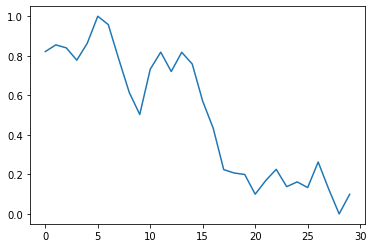

In [ ]:
####################################################################################
############################### Test Code ####################################
####################################################################################
current_ind = 1000000
term = 129600
nn_input_units = 30
scaler = MinMaxScaler()

st = time.time()

def minmax_scaler(data):
    data_min = np.min(data)
    data_max = np.max(data)
    data_scaled = (data - data_min) / (data_max - data_min)
    return data_scaled

for i in range(100):
    sampling_rate = int(term / nn_input_units)
    sampling_indices = np.arange(current_ind - term, current_ind, sampling_rate)
    sampled_data = np.array(MarketData.close)[sampling_indices]

    scaler.fit(sampled_data.reshape(-1,1))
    data_scaled = scaler.transform(sampled_data.reshape(-1,1))
    #data_scaled = minmax_scaler(sampled_data)
print('time=', (time.time() - st) / 100)
plt.plot(data_scaled)

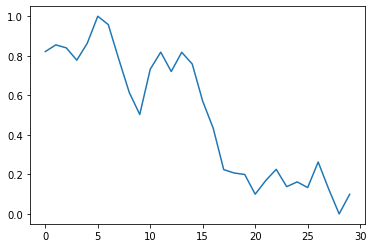

In [ ]:
plt.plot(data_scaled)

In [ ]:
####################################################################################
############################### Test Code ####################################
####################################################################################
data = MarketData.get_nn_input(1100000, 30, 60, 300, 3600, 14400, 129600)


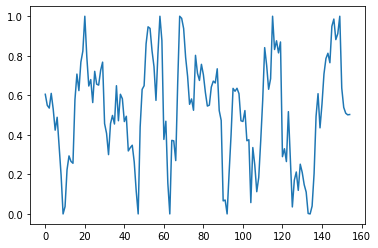

In [ ]:
plt.plot(data)

In [ ]:
np.array(data[0:-1]).flatten()

In [ ]:

data = np.zeros(1000)
d = [1]
st = time.time()
for i in range(100):
    d=list(data)
    np.array(d)
print(time.time() - st)

0.06349587440490723


In [ ]:
data[1]

array([0.45687793, 0.40736048, 0.29999071, 0.45687793, 0.49812424,
       0.45481518, 0.64853286, 0.47131602, 0.60528719, 0.58262743,
       0.46719106, 0.49400035, 0.31858197, 0.33510472, 0.34749503,
       0.26279808, 0.11596236, 0.        , 0.44037477, 0.63000123,
       0.64853286, 0.8603793 , 0.94663802, 0.93842603, 0.82544445,
       0.74525486, 0.57438627, 0.81311166, 1.        , 0.87681512])

In [ ]:
data[2]

array([0.37702873, 0.46890549, 0.15612264, 0.        , 0.37205266,
       0.36956425, 0.26982142, 0.66492079, 1.        , 0.98932435,
       0.93782227, 0.79245482, 0.696375  , 0.55451424, 0.58166878,
       0.52436238, 0.80223788, 0.71159623, 0.67524613, 0.7567137 ,
       0.70374128, 0.61470763, 0.5456208 , 0.55006792, 0.64179605,
       0.67180483, 0.66246174, 0.73416527, 0.52287856, 0.47287084])

In [ ]:
def generate_input_array(v):
    kizami = (0.05 - (-0.05)) / 10
    index = int((v + 0.05) / kizami)
    result = [0] * 10
    result[:index] = [1] * index
    if index < 10:
        result[index] = (v + 0.05 - kizami * index) / kizami
    return result

generate_input_array(0)

[1, 1, 1, 1, 1, 0.0, 0, 0, 0, 0]

In [ ]:
from IPython.terminal.shortcuts import previous_history_or_previous_completion
ratio = 0.01
side = 1
hp = 10000
cp = 9900

pt_price = (1+(side*ratio)) * hp
div = side * (pt_price - cp) / pt_price
print(pt_price)
print(div)

10100.0
0.019801980198019802


In [ ]:
(ratio + (hp - cp) *side / hp) / 0.03

0.6666666666666667

In [ ]:
import pandas as pd 
df = pd.read_csv('/content/drive/My Drive/okx-tickers.csv')
df['ticker'].iloc[0:5].to_list()

['BTC/USDT', 'ETH/USDT', 'OKB/USDT', 'OKT/USDT', 'LTC/USDT']

In [ ]:
import pandas as pd 
data = [{'ex_name':'binance', 'symbol':'BTC/USDT', 'bid':100, 'ask':200, 'average':110}, {'ex_name':'bybit', 'symbol':'BTC/USDT', 'bid':100, 'ask':200, 'average':110}, {'ex_name':'okx', 'symbol':'XRP/USDT', 'bid':100, 'ask':200, 'average':110}]
pd.DataFrame(data)

,ex_name,symbol,bid,ask,average
0,binance,BTC/USDT,100,200,110
1,bybit,BTC/USDT,100,200,110
2,okx,XRP/USDT,100,200,110


In [ ]:
d = {}
k = 'ts'
if k in d:
    d[k] += 1
else:
    d[k] = 0

In [ ]:
def test():
    return 0, -1
a, b = test()

In [ ]:
d=[1,2,3,4,5]
d[-3:]

[3, 4, 5]

In [ ]:
a = [1,2,3,4]
a.extend([0]*(120-len(a)))
a